# Premier League 17/18 season data analysis
---

<img src=source/pl_logo.png>

# Which Feature Contributes The Most to The Standing of Clubs
---
ID: 16446054 Name: Stan Wang

## Introduction:
---
* **Purpose:**This project explore the data set of Premier League 17/18 season players and the standing of Premier League 17/18 to find out which feature a club has that contributes the most to the standing of the club.
* **Key research questions:**
    * How much the average player market value affects the final points?
    * Is the new signing player average market values a better evaluation?
    * Deeper relationship among the age the value and the points
    * _Side question - fortune and fame:_
        * _Which position is the most likely to have high market vale_
        * _Which position is the most popular among the fans_
* **Brief summary:** The project first prepare the data set by dropping the unneeded columns and normalise the column names. After preparation, the exploratory data analysis(EDA) is performed to find the relationship between the points in the standing and the other features. The average player market values of a club has positive linear relationship with the points, but the relationships among the "big clubs" and the rest of clubs are more complex. New signing player average market values have a stronger correlation with the points. Lastly, the $\frac{market value}{(age)^2}$ fact has the most close relationship with the points among the explore of this project.

A side project to find out which position is the most popular among the fans and which position has the biggest chunk of market values are also included in this report. This side project is just for fun.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
if pd.__version__ != "0.23.3":
    print("Your pandas is not the version 0.23.3, there are cells you might be unable to execute due to different version")
if sns.__version__ != "0.9.0":
    print("Your seaborn is not the version 0.9.0, there are cells you might be unable to execute due to different version")

In [3]:
%matplotlib inline
matplotlib.style.use('ggplot')

In [4]:
from pylab import rcParams

In [5]:
sns.set(style="ticks")

rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 10,8
rcParams['font.size'] = 20
# rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

In [6]:
premier_league_df = pd.read_csv("epldata_final.csv")
pl_1718_table_df = pd.read_excel("premier_league_17_18_table.xlsx", index_col="Pos")

## Preprocess the datasets
---
Before analytics, a data preparation need to be done.

### Normalise the column names
Since two datasets have different column names, first step is to make the naming convention consistent.

We will follow two rules for clarity:
1. Lower case
2. Full name

In [7]:
pl_1718_table_df.columns = ["club", "played", "won", "drawn", "lost", "goals", "goals against", "goal difference", "points"]
pl_1718_table_df.head(3)

club  played  won  drawn  lost  goals  goals against  \
Pos                                                                      
1      Manchester City      38   32      4     2    106             27   
2    Manchester United      38   25      6     7     68             28   
3    Tottenham Hotspur      38   23      8     7     74             36   

     goal difference  points  
Pos                           
1                 79     100  
2                 40      81  
3                 38      77

Firstly, drop the redundant columns: "club id" and "age category"

In [8]:
premier_league_df.drop(["age_cat", "club_id"], axis=1, inplace=True)

Afterwards we will remove all the underscores

In [9]:
premier_league_df.columns = ["name", "club","age", "position",
                             "position category", "market value(Mill)", 
                             "wiki views(daily)", "fpl value", "fpl select(%)", 
                             "fpl points", "region category", "nationality", 
                             "new foreign", "big club", "new signing"]
premier_league_df.head(3)

name     club  age position  position category  \
0  Alexis Sanchez  Arsenal   28       LW                  1   
1      Mesut Ozil  Arsenal   28       AM                  1   
2       Petr Cech  Arsenal   35       GK                  4   

   market value(Mill)  wiki views(daily)  fpl value fpl select(%)  fpl points  \
0                65.0               4329       12.0        17.10%         264   
1                50.0               4395        9.5         5.60%         167   
2                 7.0               1529        5.5         5.90%         134   

   region category     nationality  new foreign  big club  new signing  
0              3.0           Chile            0         1            0  
1              2.0         Germany            0         1            0  
2              2.0  Czech Republic            0         1            0

### Change numeric value to meaningful string 
As this project is for exploratory data analysis only, meaningful string will be more intuitively than numeric code

In [10]:
# First to check if anyother category exist
premier_league_df["position category"].unique()

array([1, 4, 3, 2])

In [11]:
def change_position_cat_to_string(x):
    if type(x) == str:
        return x
    switcher = {
        1: "attackers",
        2: "midfielders",
        3: "defenders",
        4: "goalkeepers"
    }
    
    return switcher.get(x, "Invalid category")

In [12]:
premier_league_df["position category"] = premier_league_df["position category"].apply(change_position_cat_to_string)

In [13]:
premier_league_df.head(3)

name     club  age position position category  \
0  Alexis Sanchez  Arsenal   28       LW         attackers   
1      Mesut Ozil  Arsenal   28       AM         attackers   
2       Petr Cech  Arsenal   35       GK       goalkeepers   

   market value(Mill)  wiki views(daily)  fpl value fpl select(%)  fpl points  \
0                65.0               4329       12.0        17.10%         264   
1                50.0               4395        9.5         5.60%         167   
2                 7.0               1529        5.5         5.90%         134   

   region category     nationality  new foreign  big club  new signing  
0              3.0           Chile            0         1            0  
1              2.0         Germany            0         1            0  
2              2.0  Czech Republic            0         1            0

In [14]:
premier_league_df["region category"].unique()

array([ 3.,  2.,  1.,  4., nan])

We can see that there are invalid value inside "region category" column. Next we want to locate those value can change them to consitent value.

In [15]:
# TODO: Ask Teo, seems chain assignment doesn't work
idx = premier_league_df[premier_league_df["region category"].isnull()].index
premier_league_df[premier_league_df["region category"].isnull()]

name          club  age position position category  \
188  Steve Mounie  Huddersfield   22       CF         attackers   

     market value(Mill)  wiki views(daily)  fpl value fpl select(%)  \
188                 5.5                 56        6.0         0.60%   

     fpl points  region category nationality  new foreign  big club  \
188           0              NaN       Benin            0         0   

     new signing  
188            0

In [16]:
_ = premier_league_df.set_value(index=idx, col="region category", value= 4)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


In [17]:
def change_region_cat_to_string(x):
    if type(x) == str:
        return x
    switcher = {
        1: "England",
        2: "EU",
        3: "Americas",
        4: "Rest of World"
    }
    
    return switcher.get(x, "Invalid category")

In [18]:
premier_league_df["region category"] = premier_league_df["region category"].apply(change_region_cat_to_string)

In [19]:
premier_league_df.head(3)

name     club  age position position category  \
0  Alexis Sanchez  Arsenal   28       LW         attackers   
1      Mesut Ozil  Arsenal   28       AM         attackers   
2       Petr Cech  Arsenal   35       GK       goalkeepers   

   market value(Mill)  wiki views(daily)  fpl value fpl select(%)  fpl points  \
0                65.0               4329       12.0        17.10%         264   
1                50.0               4395        9.5         5.60%         167   
2                 7.0               1529        5.5         5.90%         134   

  region category     nationality  new foreign  big club  new signing  
0        Americas           Chile            0         1            0  
1              EU         Germany            0         1            0  
2              EU  Czech Republic            0         1            0

In [20]:
premier_league_df["big club"] = premier_league_df["big club"].apply(lambda x: True if x == 1 else False)
premier_league_df["new foreign"] = premier_league_df["new foreign"].apply(lambda x: True if x == 1 else False)
premier_league_df["new signing"] = premier_league_df["new signing"].apply(lambda x: True if x == 1 else False)
premier_league_df.head(3)

name     club  age position position category  \
0  Alexis Sanchez  Arsenal   28       LW         attackers   
1      Mesut Ozil  Arsenal   28       AM         attackers   
2       Petr Cech  Arsenal   35       GK       goalkeepers   

   market value(Mill)  wiki views(daily)  fpl value fpl select(%)  fpl points  \
0                65.0               4329       12.0        17.10%         264   
1                50.0               4395        9.5         5.60%         167   
2                 7.0               1529        5.5         5.90%         134   

  region category     nationality  new foreign  big club  new signing  
0        Americas           Chile        False      True        False  
1              EU         Germany        False      True        False  
2              EU  Czech Republic        False      True        False

### Change "new signing" column values
The original data set column "new foreign" doesn't count as new signing which doesn't make sense.

In [21]:
premier_league_df["new signing"] = (premier_league_df["new signing"] == True) | (premier_league_df["new foreign"] == True)

### Normalise the club names
Since the data come from two dataset, the club names aren't consistent.

In [22]:
pl_1718_table_df.head(3)

club  played  won  drawn  lost  goals  goals against  \
Pos                                                                      
1      Manchester City      38   32      4     2    106             27   
2    Manchester United      38   25      6     7     68             28   
3    Tottenham Hotspur      38   23      8     7     74             36   

     goal difference  points  
Pos                           
1                 79     100  
2                 40      81  
3                 38      77

In [23]:
club_name_alphabet_s = pl_1718_table_df["club"].sort_values().reset_index(drop=True)
def change_clubs_name(x):
    idx=0
    for name in premier_league_df["club"].unique():
        if x != name:
            idx += 1
        else:
            break
    if x != club_name_alphabet_s[idx]:
        x = club_name_alphabet_s[idx]
    return x
    

In [24]:
premier_league_df["club"] = premier_league_df["club"].apply(change_clubs_name)

In [25]:
premier_league_df["club"].unique()

array(['Arsenal', 'Bournemouth', u'Brighton & Hove Albion', 'Burnley',
       'Chelsea', u'Crystal Palace', 'Everton', u'Huddersfield Town',
       u'Leicester City', 'Liverpool', u'Manchester City',
       u'Manchester United', u'Newcastle United', 'Southampton',
       u'Stoke City', u'Swansea City', u'Tottenham Hotspur', 'Watford',
       u'West Bromwich Albion', u'West Ham United'], dtype=object)

Now the club names are follow the same convention: full name with space as separator.

## Exploratory Data Analysis
---

In [26]:
club_mean_df = premier_league_df.groupby("club").mean().drop(["fpl value", "fpl points"], axis=1).sort_values("market value(Mill)", ascending=False)

In [27]:
club_mean_df.head(3)

age  market value(Mill)  wiki views(daily)  new foreign  \
club                                                                           
Manchester City    27.00             28.2000            1474.35          0.1   
Chelsea            27.05             27.6775            1773.80          0.1   
Tottenham Hotspur  25.65             23.0000            1213.95          0.0   

                   big club  new signing  
club                                      
Manchester City         1.0         0.35  
Chelsea                 1.0         0.30  
Tottenham Hotspur       1.0         0.20

### Merge the club average value with the standings table
Firstly let's see the big picture of the dataset before we get closer.

In [28]:
# Reset index to run on the labs machine which has lower version pandas
club_mean_merge_df = pd.merge(club_mean_df.reset_index(), pl_1718_table_df, on="club").drop(["played"], axis=1)

In [29]:
club_mean_merge_df.head(3)

club    age  market value(Mill)  wiki views(daily)  \
0    Manchester City  27.00             28.2000            1474.35   
1            Chelsea  27.05             27.6775            1773.80   
2  Tottenham Hotspur  25.65             23.0000            1213.95   

   new foreign  big club  new signing  won  drawn  lost  goals  goals against  \
0          0.1       1.0         0.35   32      4     2    106             27   
1          0.1       1.0         0.30   21      7    10     62             38   
2          0.0       1.0         0.20   23      8     7     74             36   

   goal difference  points  
0               79     100  
1               24      70  
2               38      77

Change the column names to more intuitive names

In [30]:
club_mean_merge_df.columns = ["club", "avg age", "avg market value(Mill)", "avg wiki views(daily)", "new foreign portion", "big club", "new signing portion", "won", "drawn", "lost", "goals", "goals against", "goal difference", "points"]

Text(0.5,0.98,'Scatter matrix among the average key features')

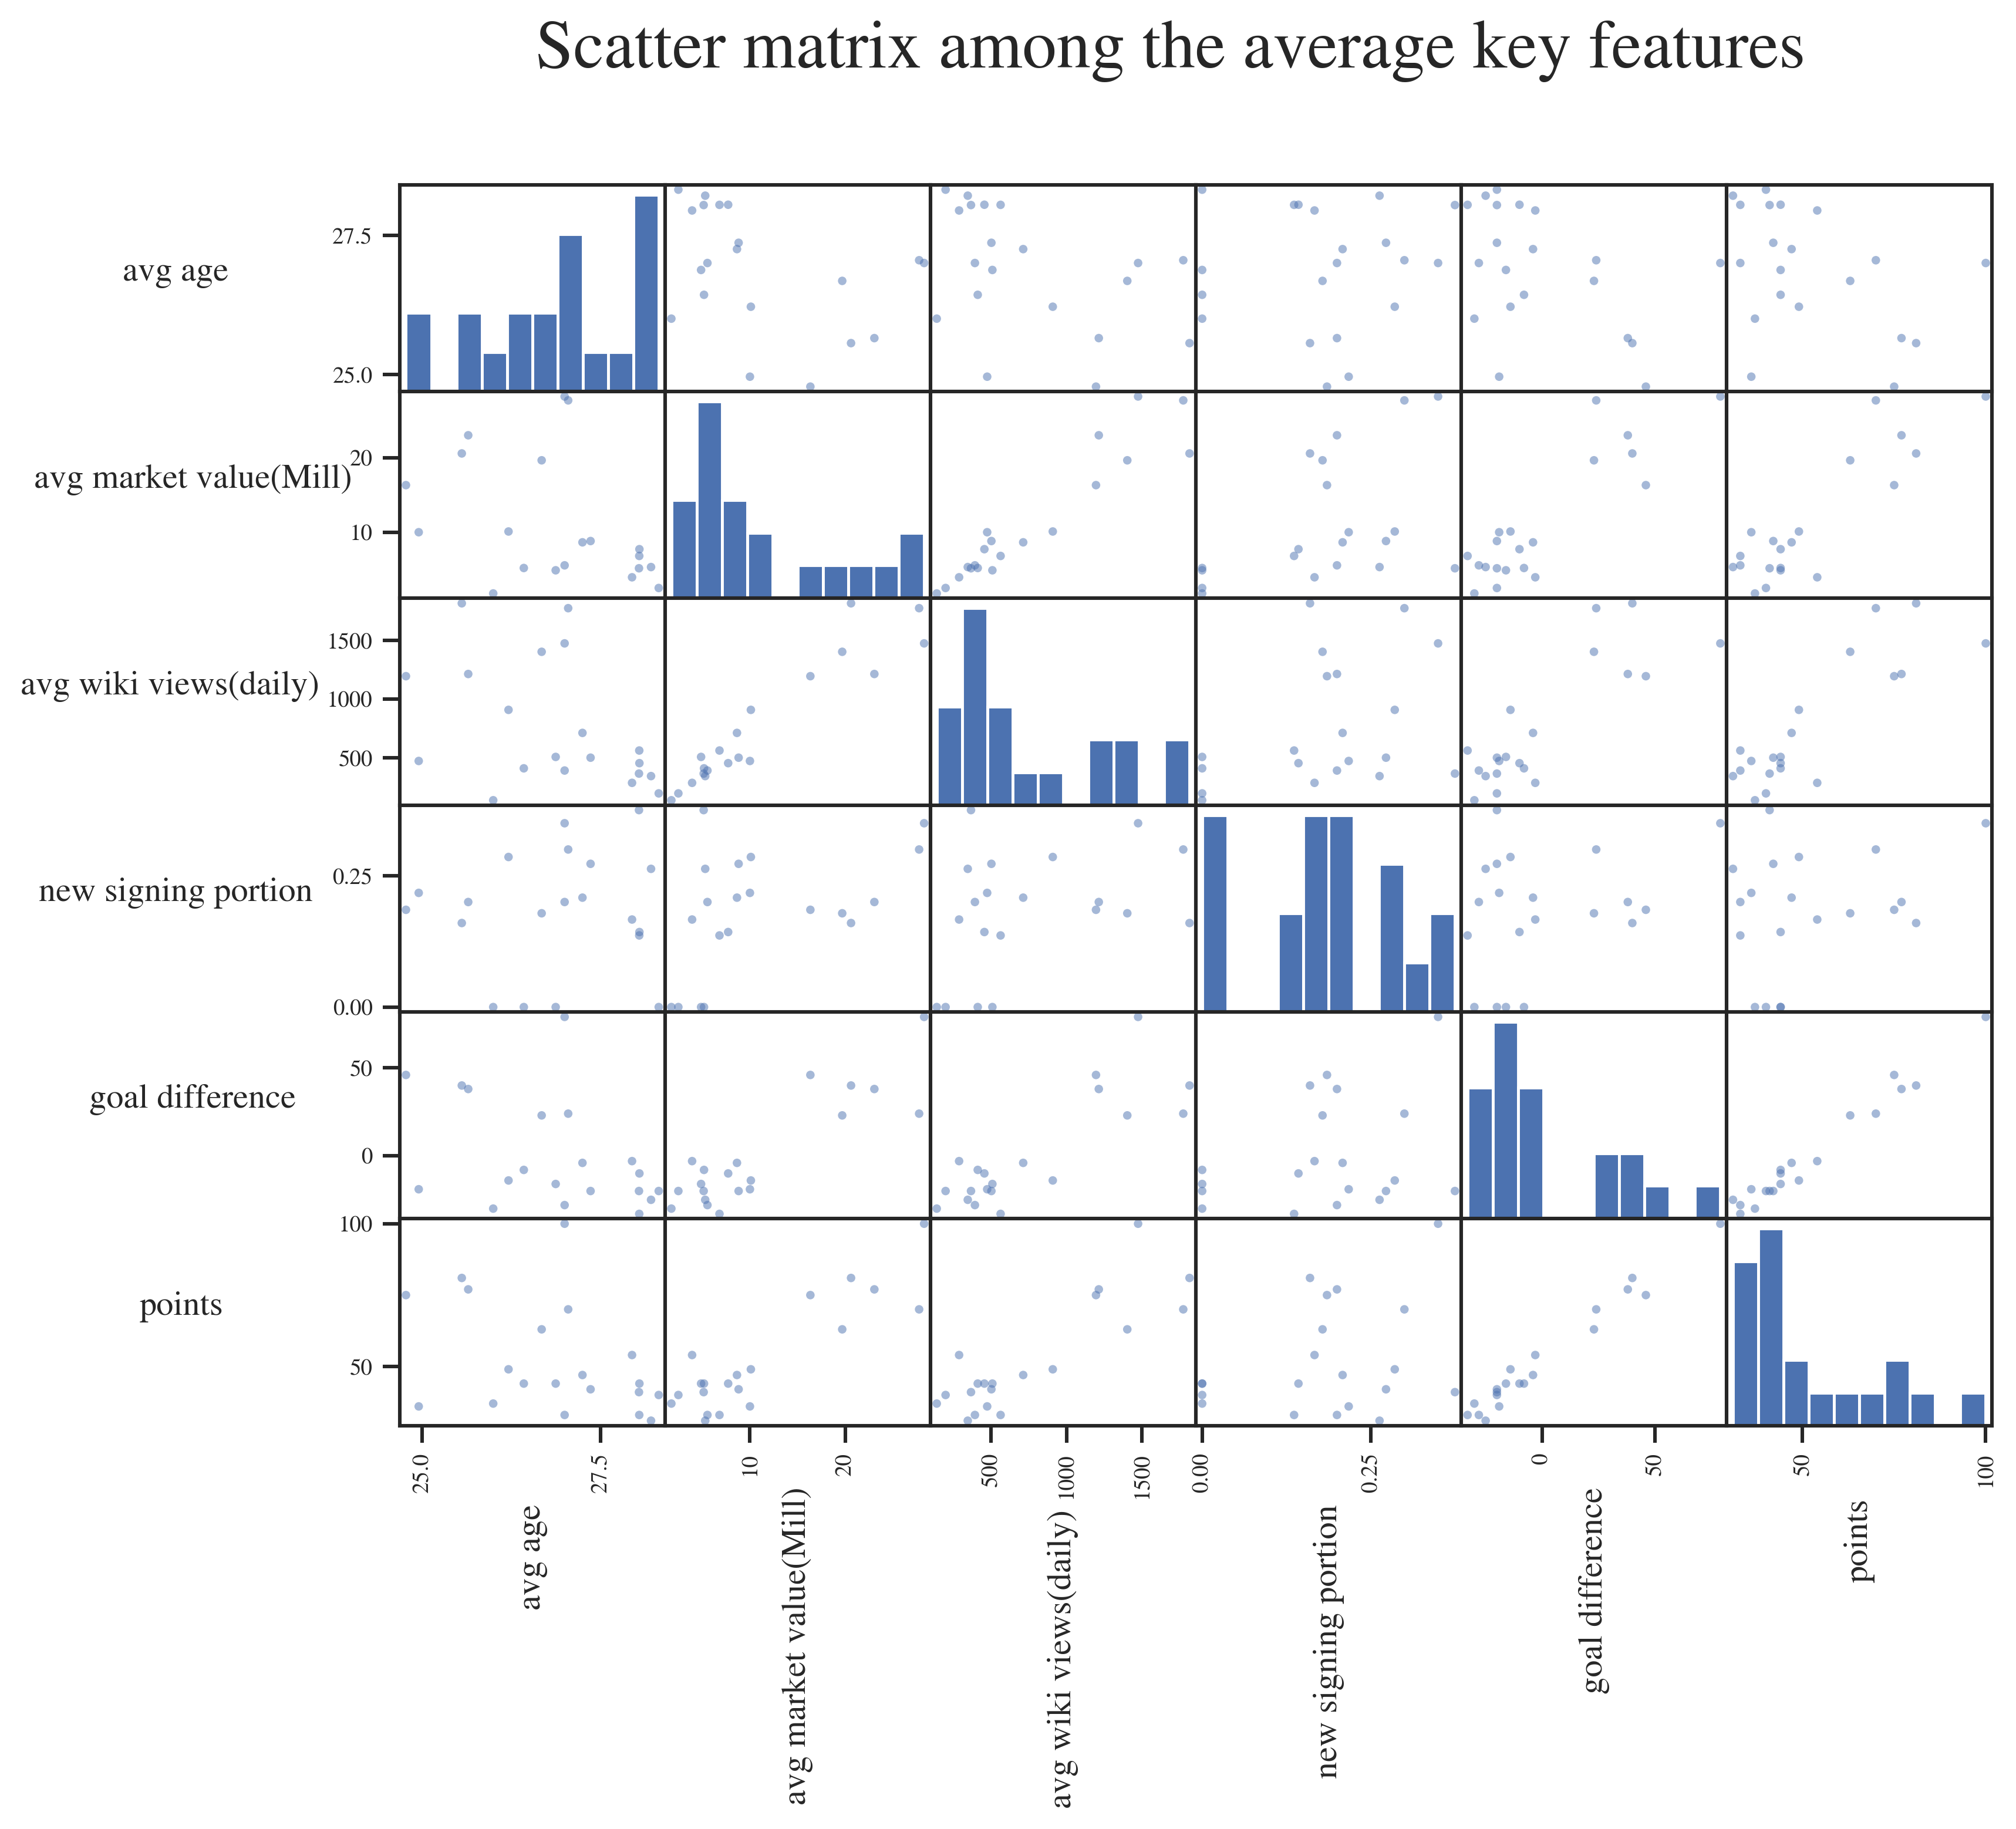

In [31]:
axs = pd.plotting.scatter_matrix(club_mean_merge_df[["avg age", "avg market value(Mill)", "avg wiki views(daily)", "new signing portion", "goal difference", "points"]], diagonal="hist")
n = 6
for x in range(n):
    for y in range(n):
        # To get the axis of subplots
        ax = axs[x, y]
        # To make x axis labels horizontal
        ax.xaxis.label.set_rotation(90)
        # To make y axis labels horizontal
        ax.yaxis.label.set_rotation(0)
        # To make sure y labels are outside the plot
        ax.yaxis.labelpad = 55
        
plt.suptitle("Scatter matrix among the average key features")

### Observations from above scatter matrices
---
1. The age feature doesn't have a clear pattern with other features.
2. The daily wiki page views has a clearly positive linear relationship with the average market value a club has. This relationship also exists between the market value and the goal difference, the market value and the points.
3. The higher goal difference a club can achieve, the more points they can get.

_Note: Goal difference is the difference between the goals and the goal against a club has_

---
Let's take a look at the correlations to help understanding the scatter matrices plot more numerically. The red colour outstanding the strong correlations greater than 0.8 or less than -0.8.

In [32]:
def color_strong_corr_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for strong correlations
    , black otherwise.
    """
    color = 'red' if (val > 0.8 or val < -0.8)  else 'black'
    return 'color: %s' % color

In [33]:
club_mean_merge_df.corr().style.applymap(color_strong_corr_red)

### Observations from correlation table:
---
1. Big club(top 6 market values) do have strong relationship with multiple features: popularity(wiki views), higher goal difference, and likely to have more points.
2. Surprisingly the portion of new signing doesn't affect the points much.
3. Further prove the observation we gained from scatter matrices that people love the club with higher market values.

## How much the average player market value affects the final points
A obvious way to know which club has done a good job is through the points in standing table, which the greatest points club wins the champion.

Through the big picture observation we gain from the last section, we know there is a correlation between market values a club has and the points it gets at the end of the season. However, how much is the effect of market values a club has towards the ranking they achieve needs more investigations.

In [34]:
sns.set_style("whitegrid")
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'

In [35]:
sorted_market_value_idx = premier_league_df.groupby(["club"])["market value(Mill)"].mean().sort_values(ascending=False).index

In [36]:
# Keep the rank
pl_1718_table_df["rank"] = pl_1718_table_df.index
# Reorder the table by market valur
rank_se = pl_1718_table_df.set_index(keys="club").reindex(sorted_market_value_idx)["rank"]

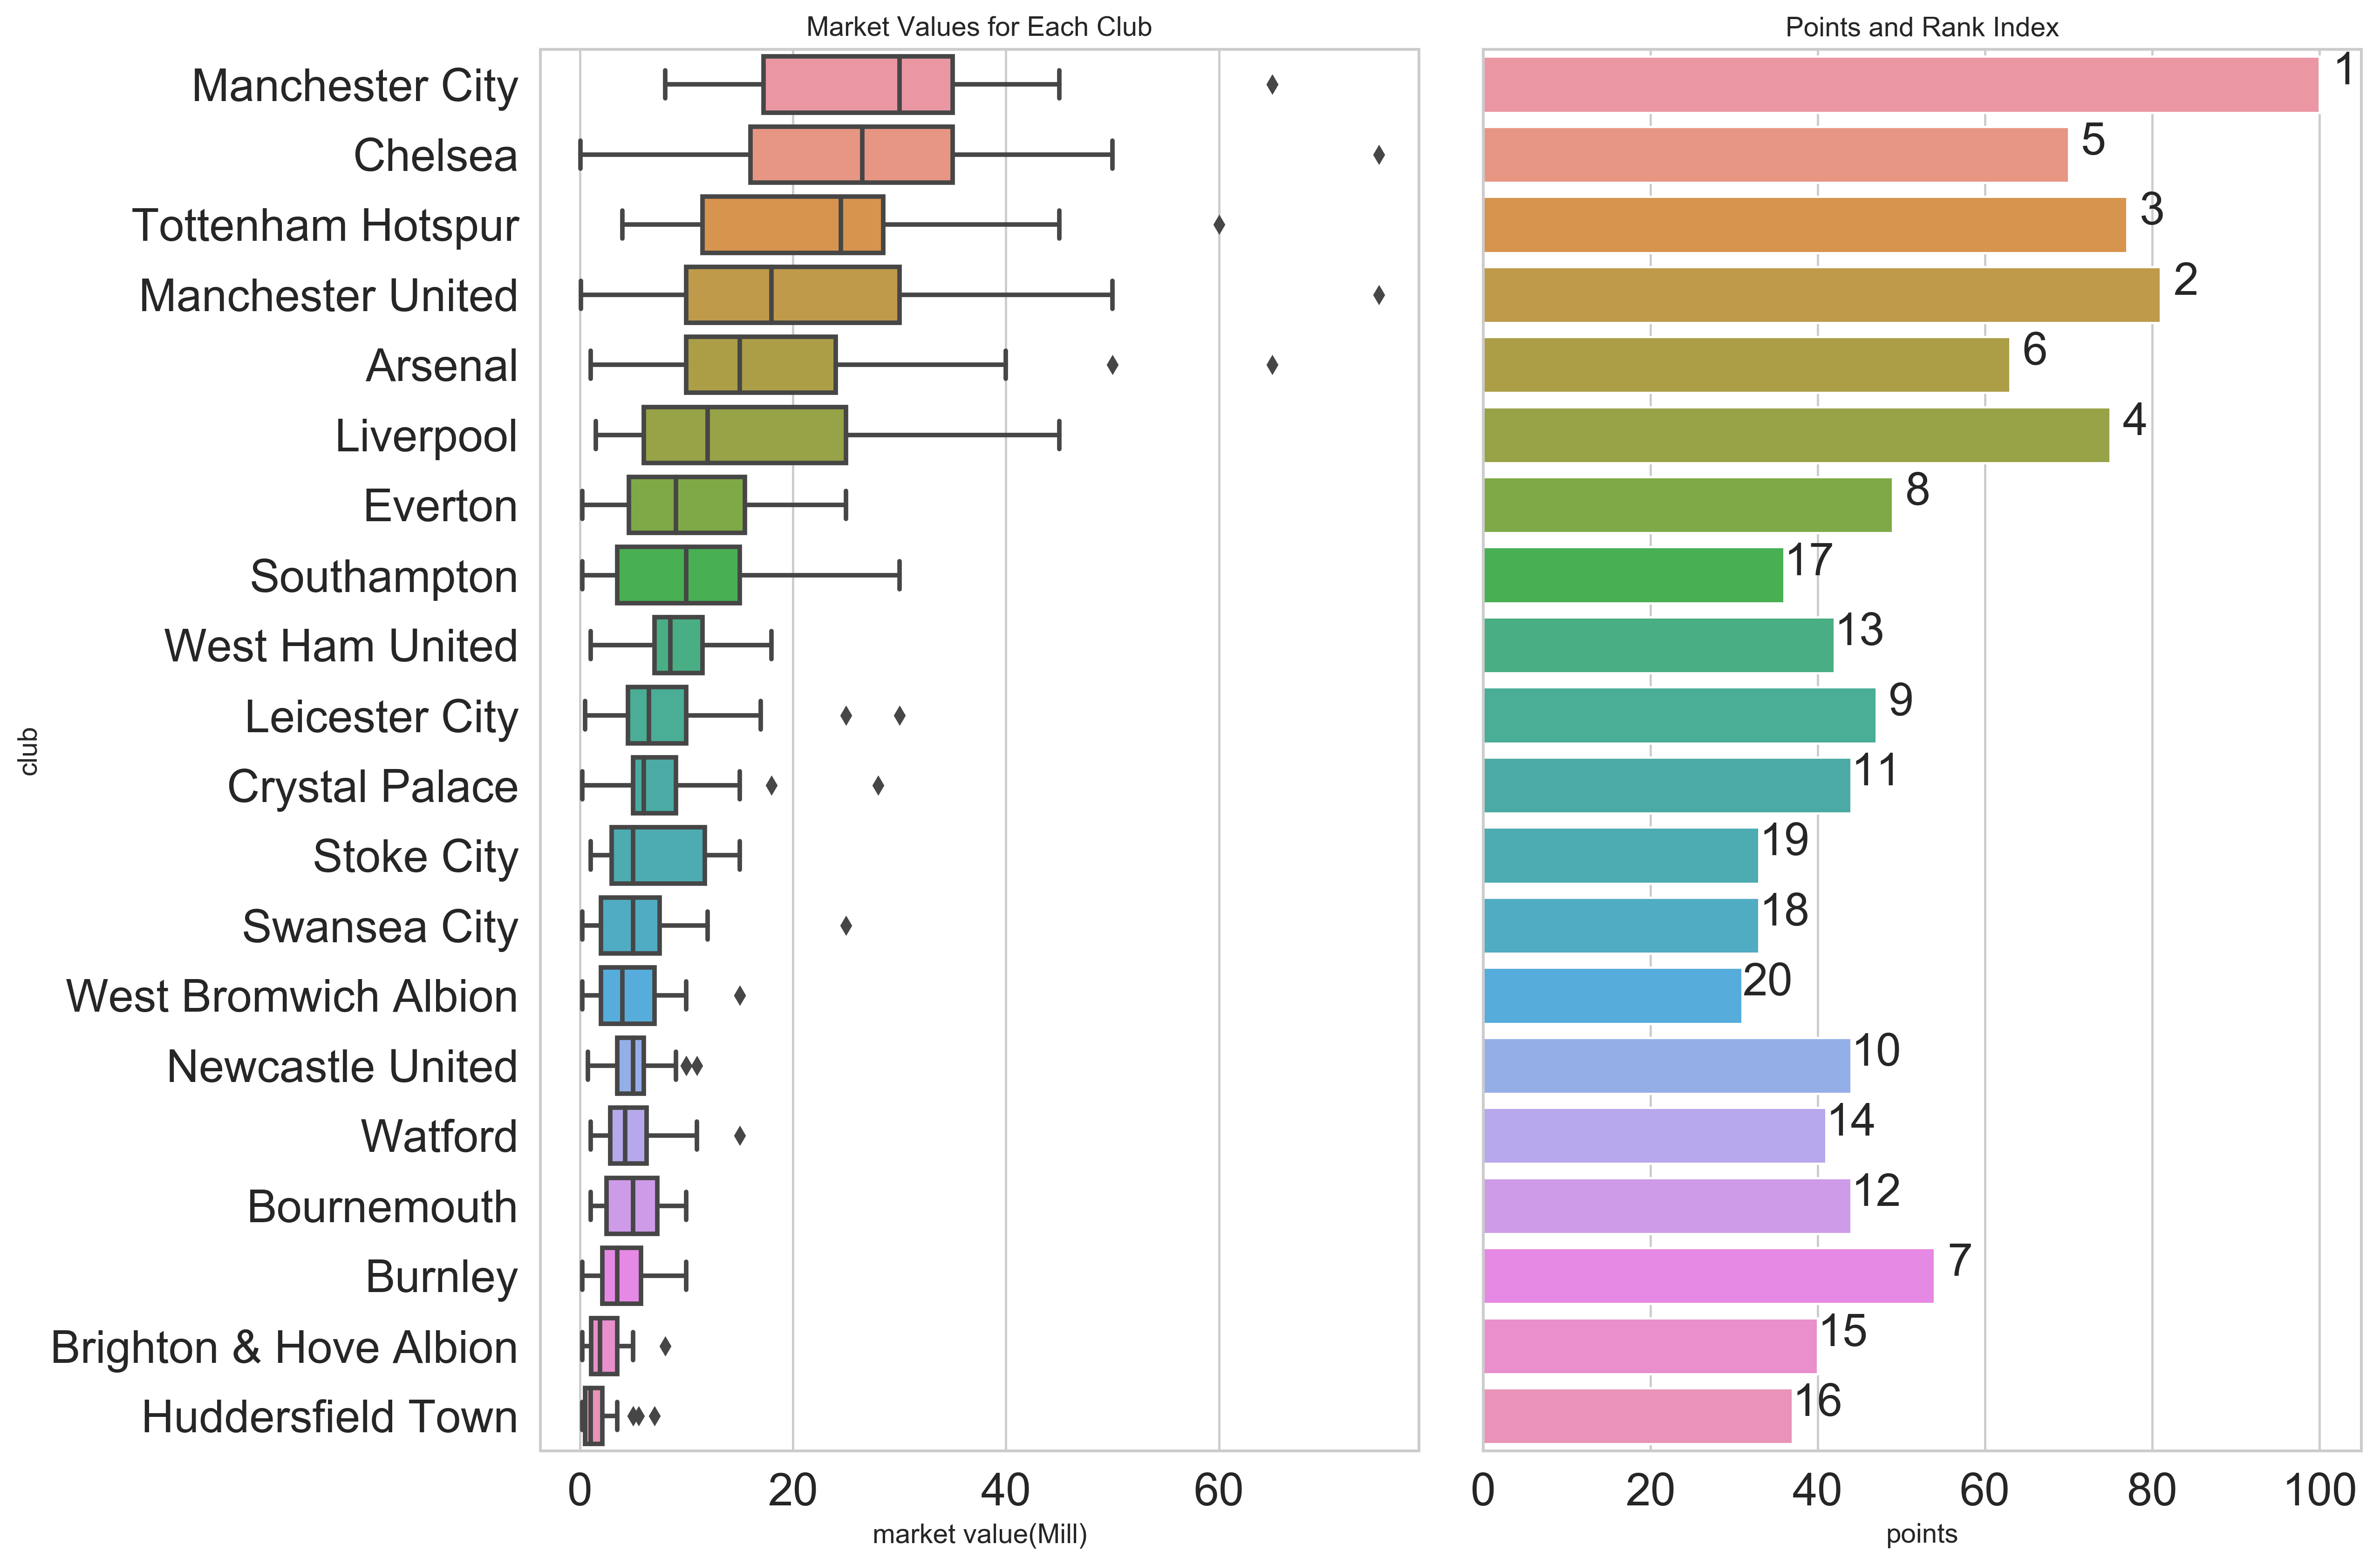

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


# plot_beautify(ax1)
# plot_beautify(ax2)

sns.boxplot(x="market value(Mill)", y="club", data=premier_league_df, order=sorted_market_value_idx, ax=ax1, )
sns.barplot(x="points", y="club", data=pl_1718_table_df, ax=ax2, order=sorted_market_value_idx)

for p, rank in zip(ax2.patches, rank_se):
    width = p.get_width()
    ax2.text(width + 3,
             p.get_y() + p.get_height()/2.0,
             rank,
             ha="center"
            )
    
ax2.set_ylabel("")
ax1.set_title("Market Values for Each Club")
ax2.set_title("Points and Rank Index")

f.tight_layout()

# TODO: Remove ax2 x axis number and add the points to the top of bar

As we sorted the club orders by the club mean market values, the points a club gained at the end of season is not strictly fit for the order. **Chelsea** have the second largest mean market value but only end up with fifth in the standings, even cannot join the **UEFA Champions League** next year. Same case happened on **Southampton**, with the second largest mean market value among the clubs that are not "the big 6" but end up with almost relegation standing.

Text(0.5,0.98,'Avg market value per club with the points it got')

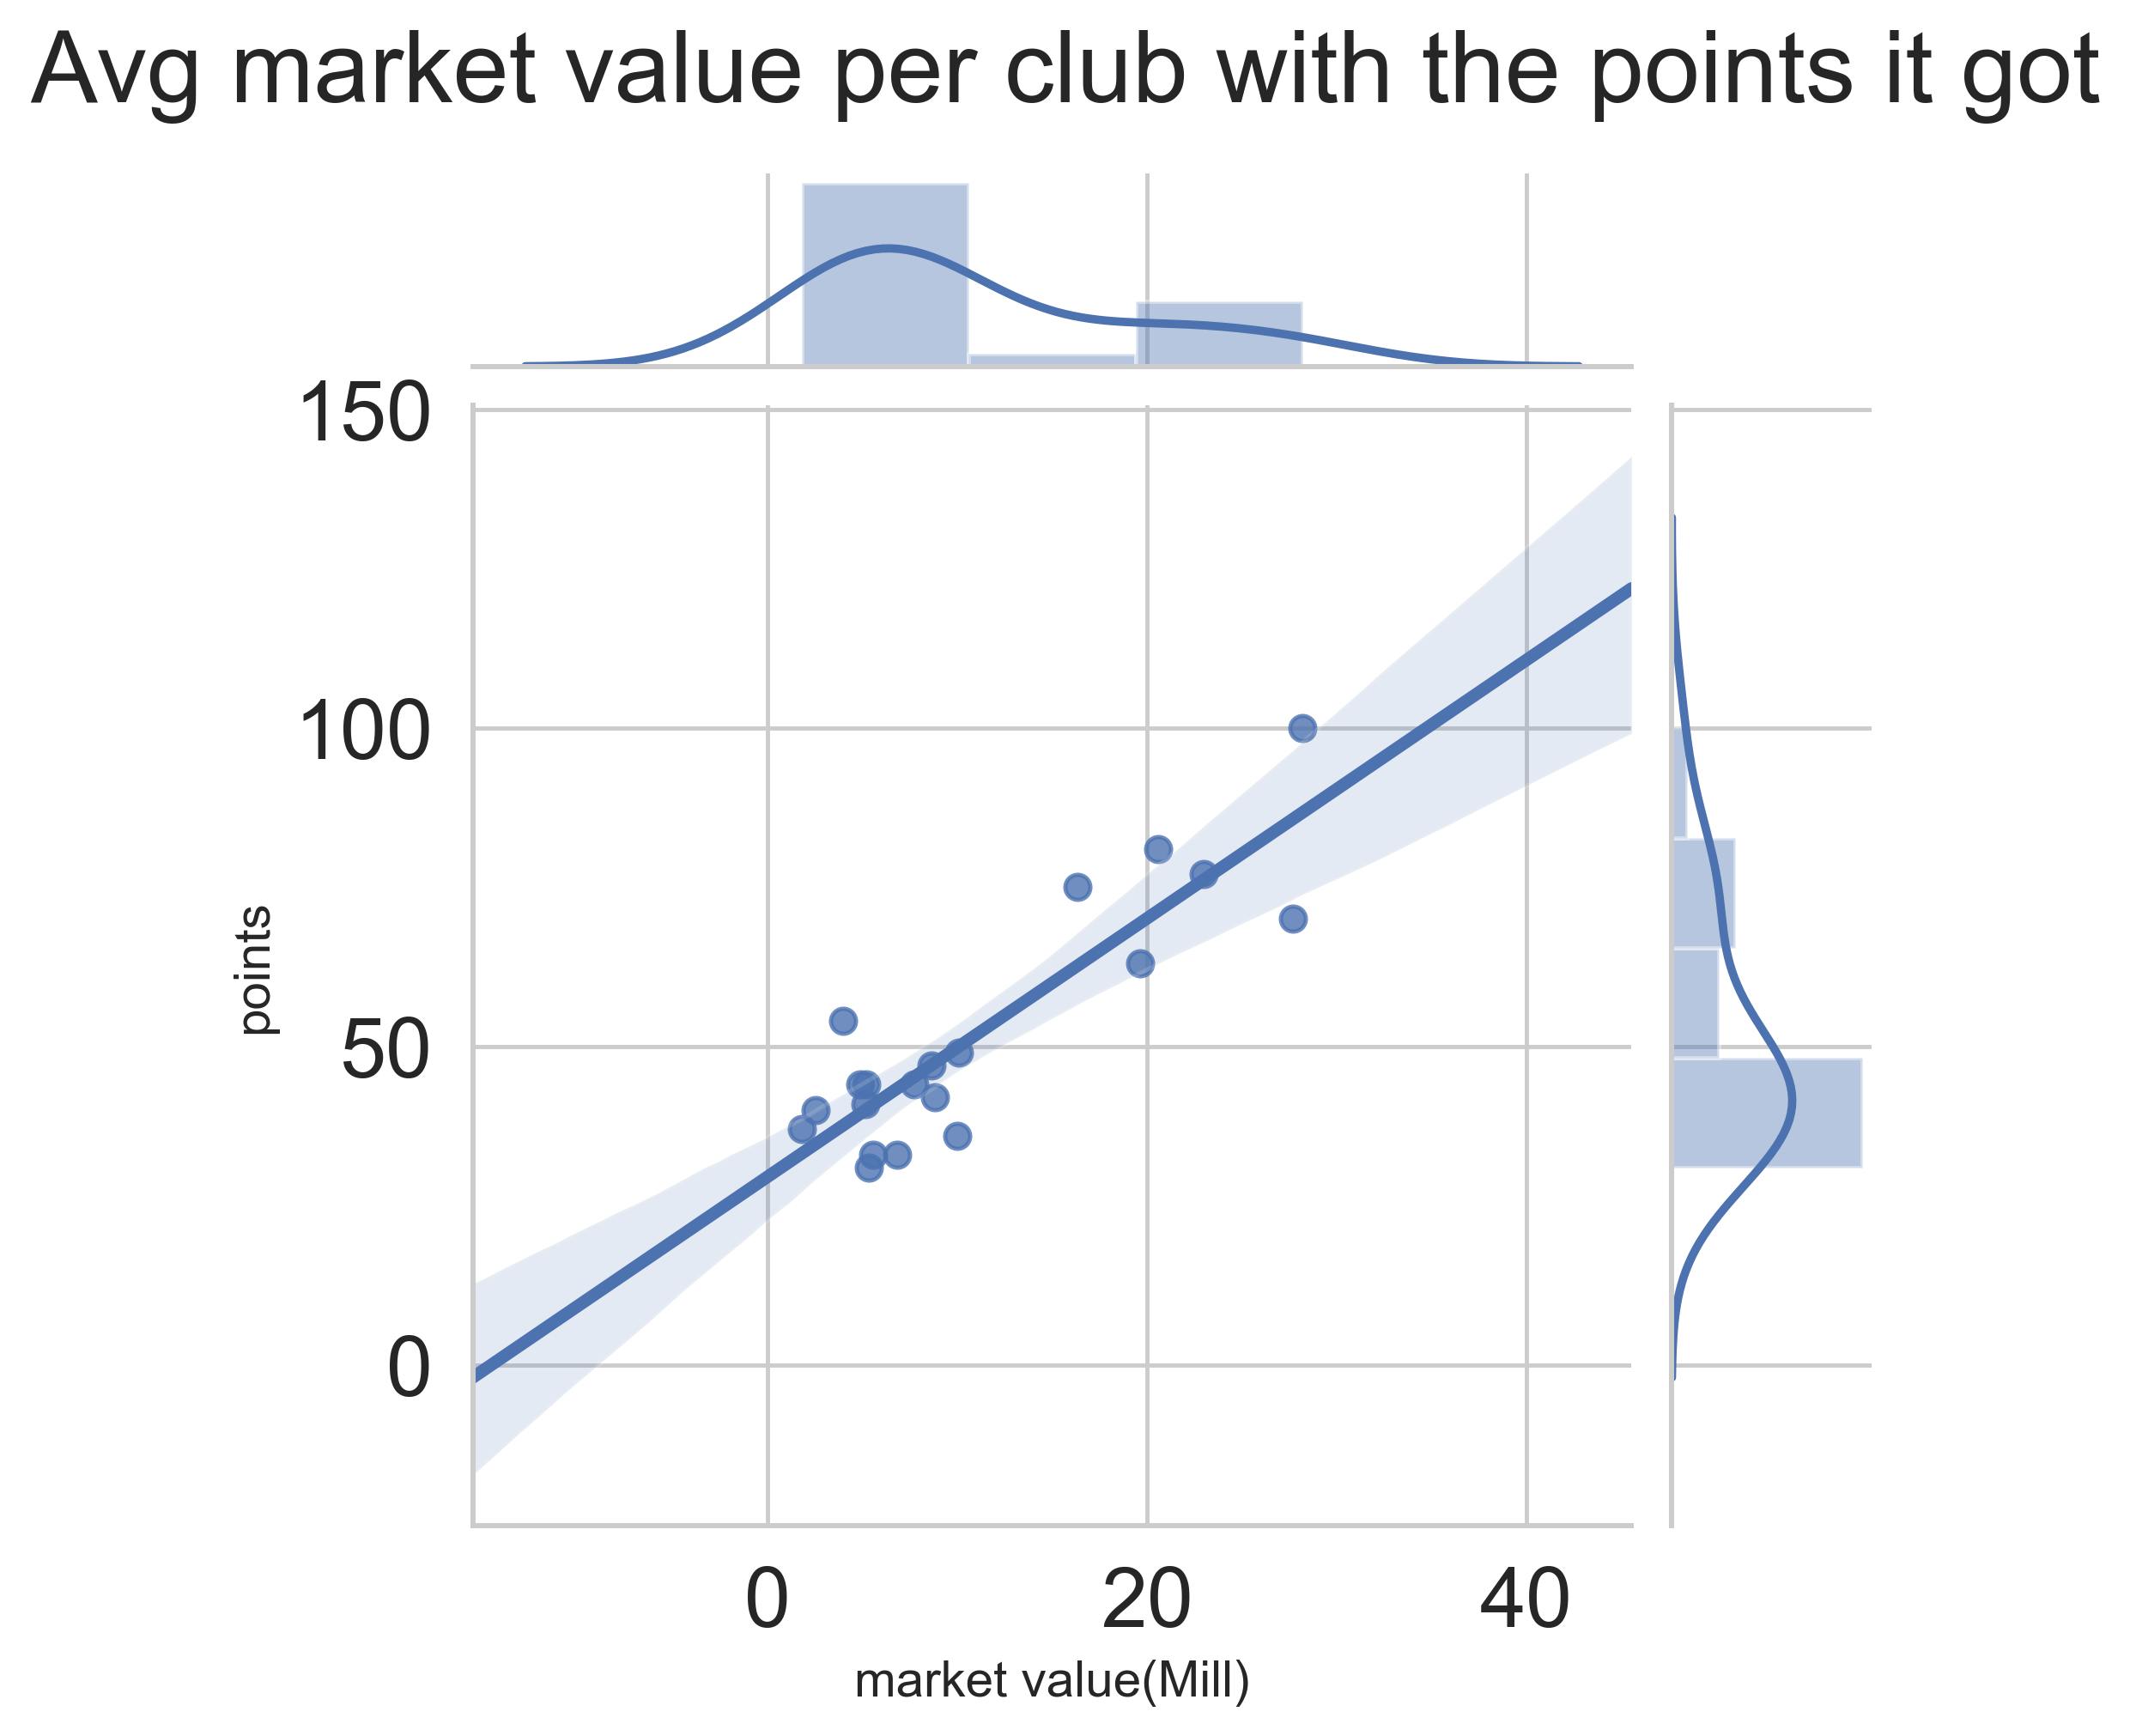

In [38]:
sns.jointplot(premier_league_df.groupby(["club"])["market value(Mill)"].mean().sort_values(ascending=False), pl_1718_table_df.set_index(keys="club").reindex(sorted_market_value_idx)["points"], kind="reg")
plt.subplots_adjust(top=0.9)
plt.suptitle("Avg market value per club with the points it got")


From the join plot we can have two observations:
1. The more total market values a club has, the more the points they will gain at the end of season
2. Premier league is clearly divided into two groups by the total market values a club has, one is the **big 6 clubs** and the other one is the rest of clubs which the market values are less than or around 300 million euro
3. As the blue area is relatively narrow, the linear regression shows a confidence contain the best-fit regression line which represents that the data set have a relatively good linear relationship.

If we plot it in _kde_ mode then we can clearly see two clusters in the chart.

Text(0.5,0.98,'Avg market value per club with the points it got')

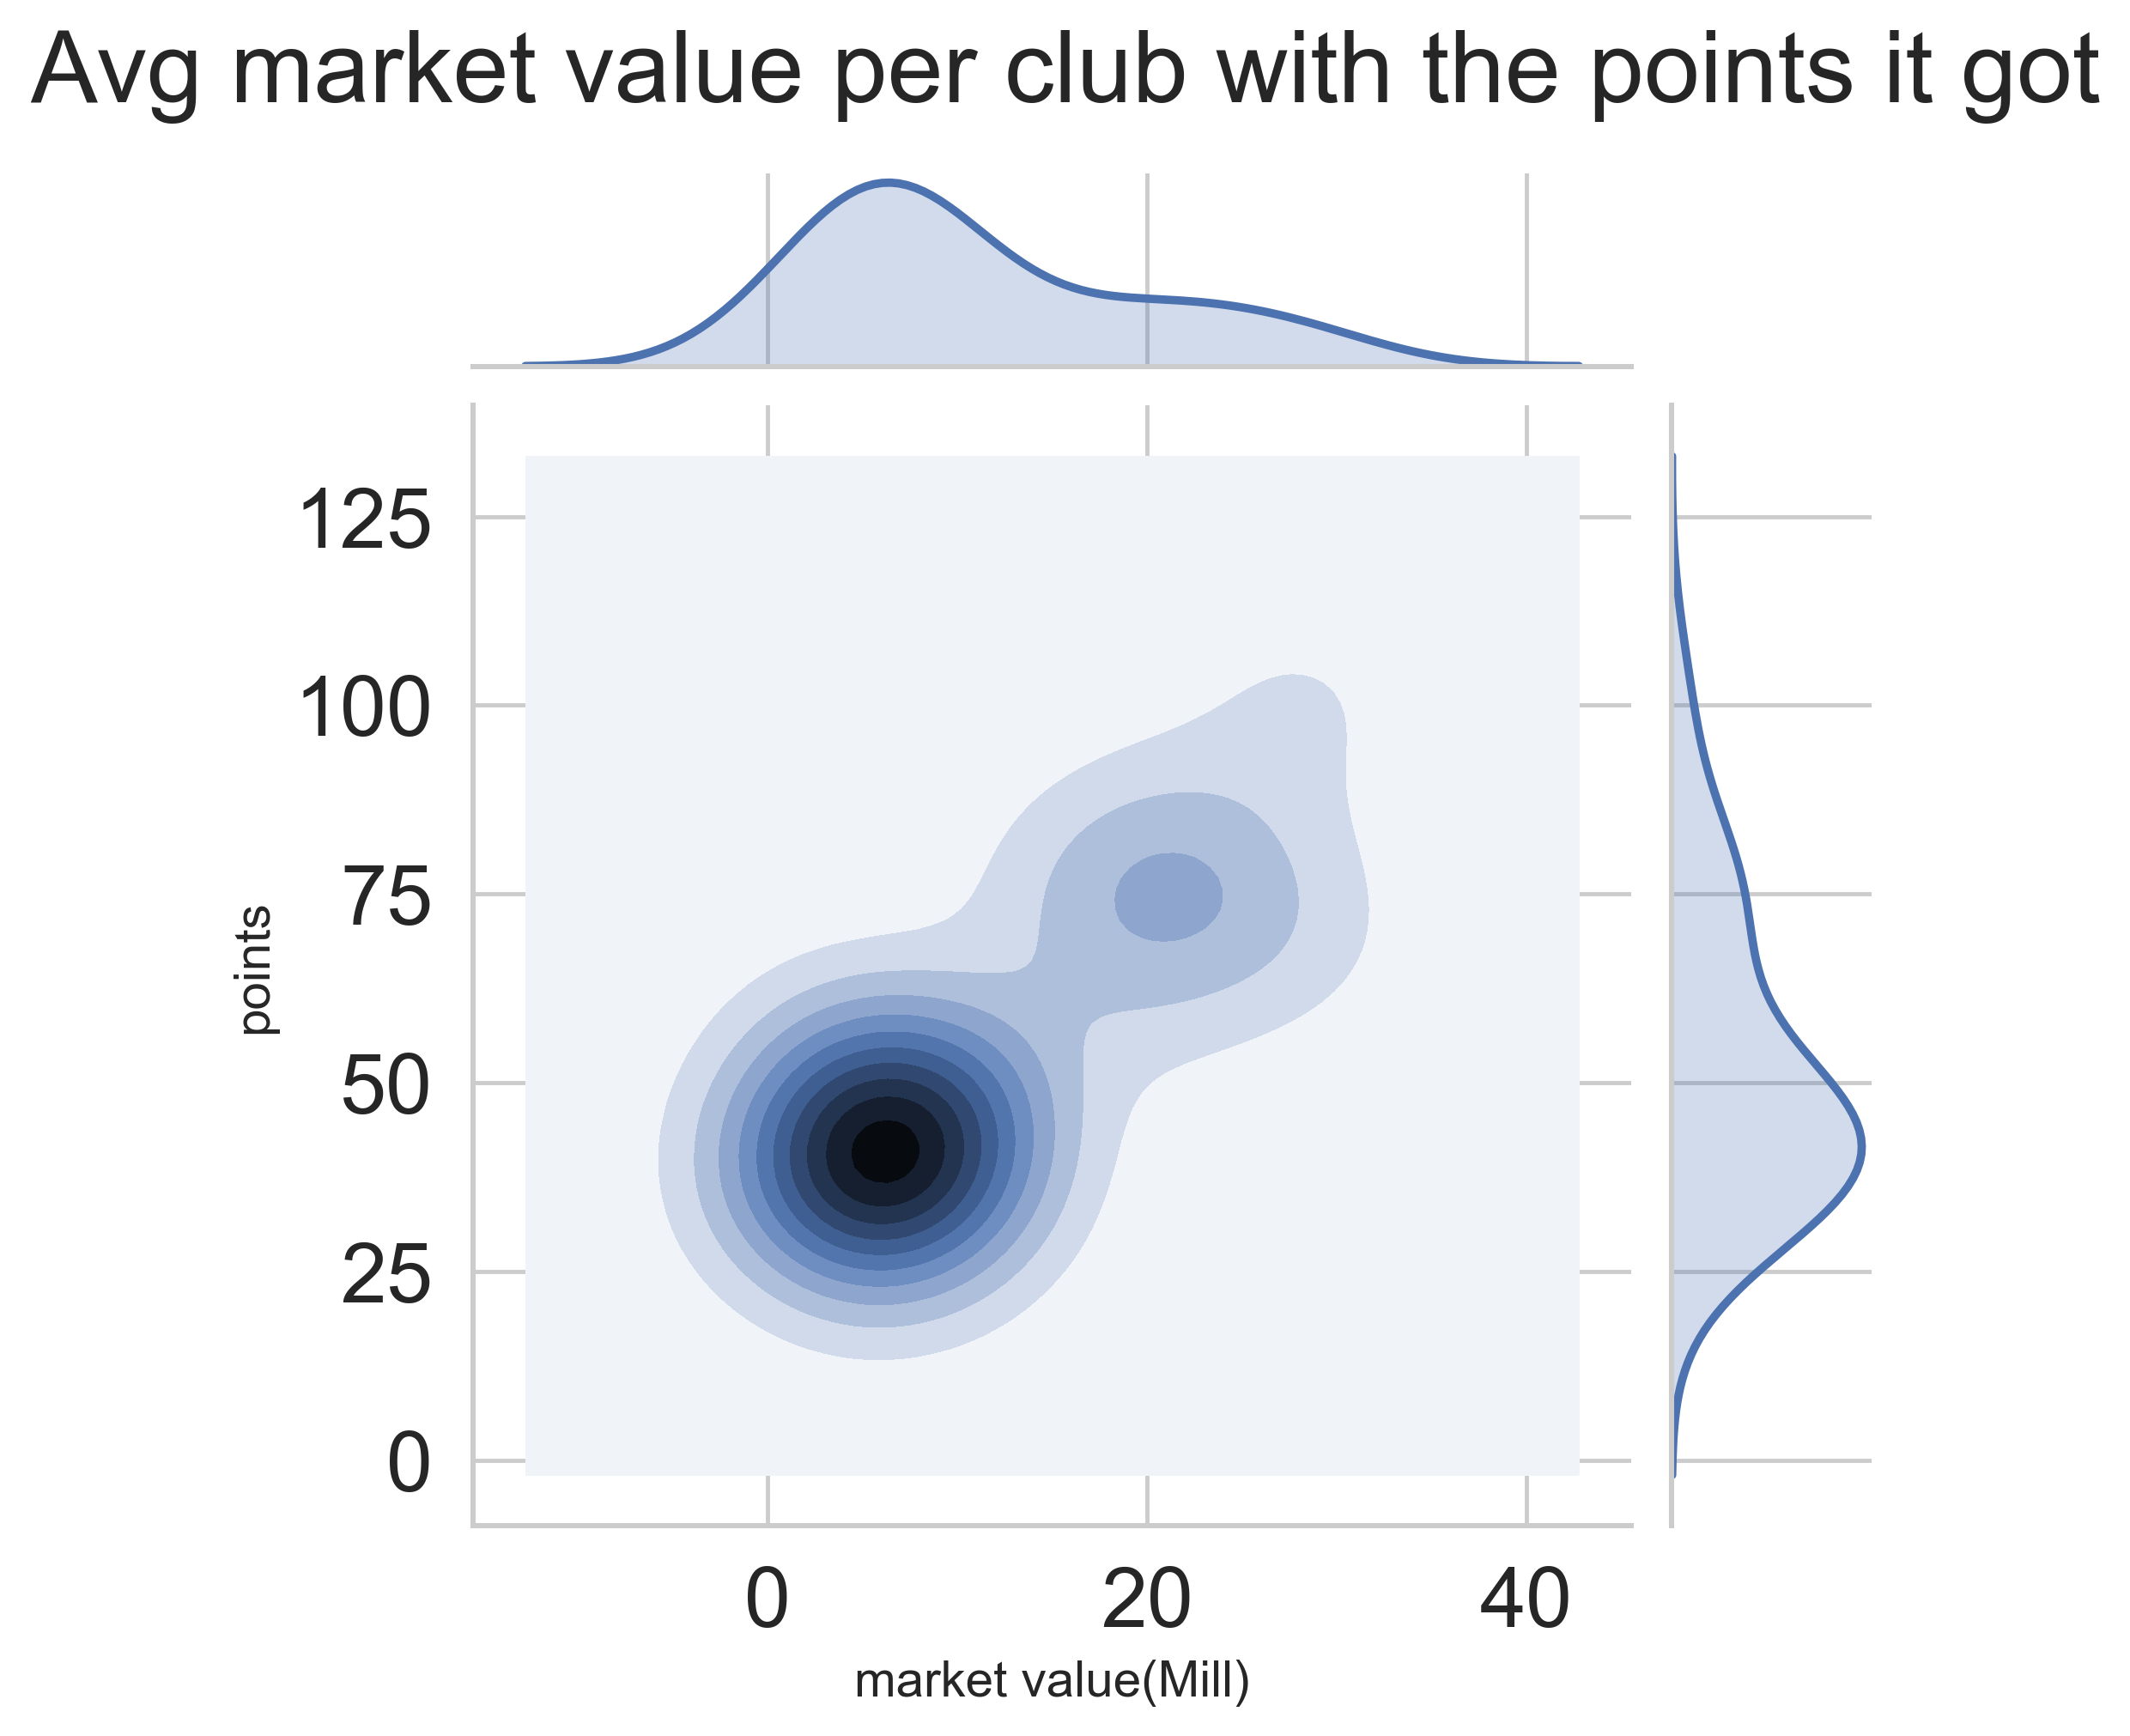

In [39]:
sns.jointplot(premier_league_df.groupby(["club"])["market value(Mill)"].mean().sort_values(ascending=False), pl_1718_table_df.set_index(keys="club").reindex(sorted_market_value_idx)["points"], kind="kde")
plt.subplots_adjust(top=0.9)
plt.suptitle("Avg market value per club with the points it got")

### Look into two groups
---
Separate the premier league with two groups according to the plotting above. One is the "big clubs", the other one is the rest of the league.

In [40]:
big_6_index = pl_1718_table_df.set_index(keys="club").reindex(sorted_market_value_idx).index[:6]

Text(0.5,0.98,'Big clubs')

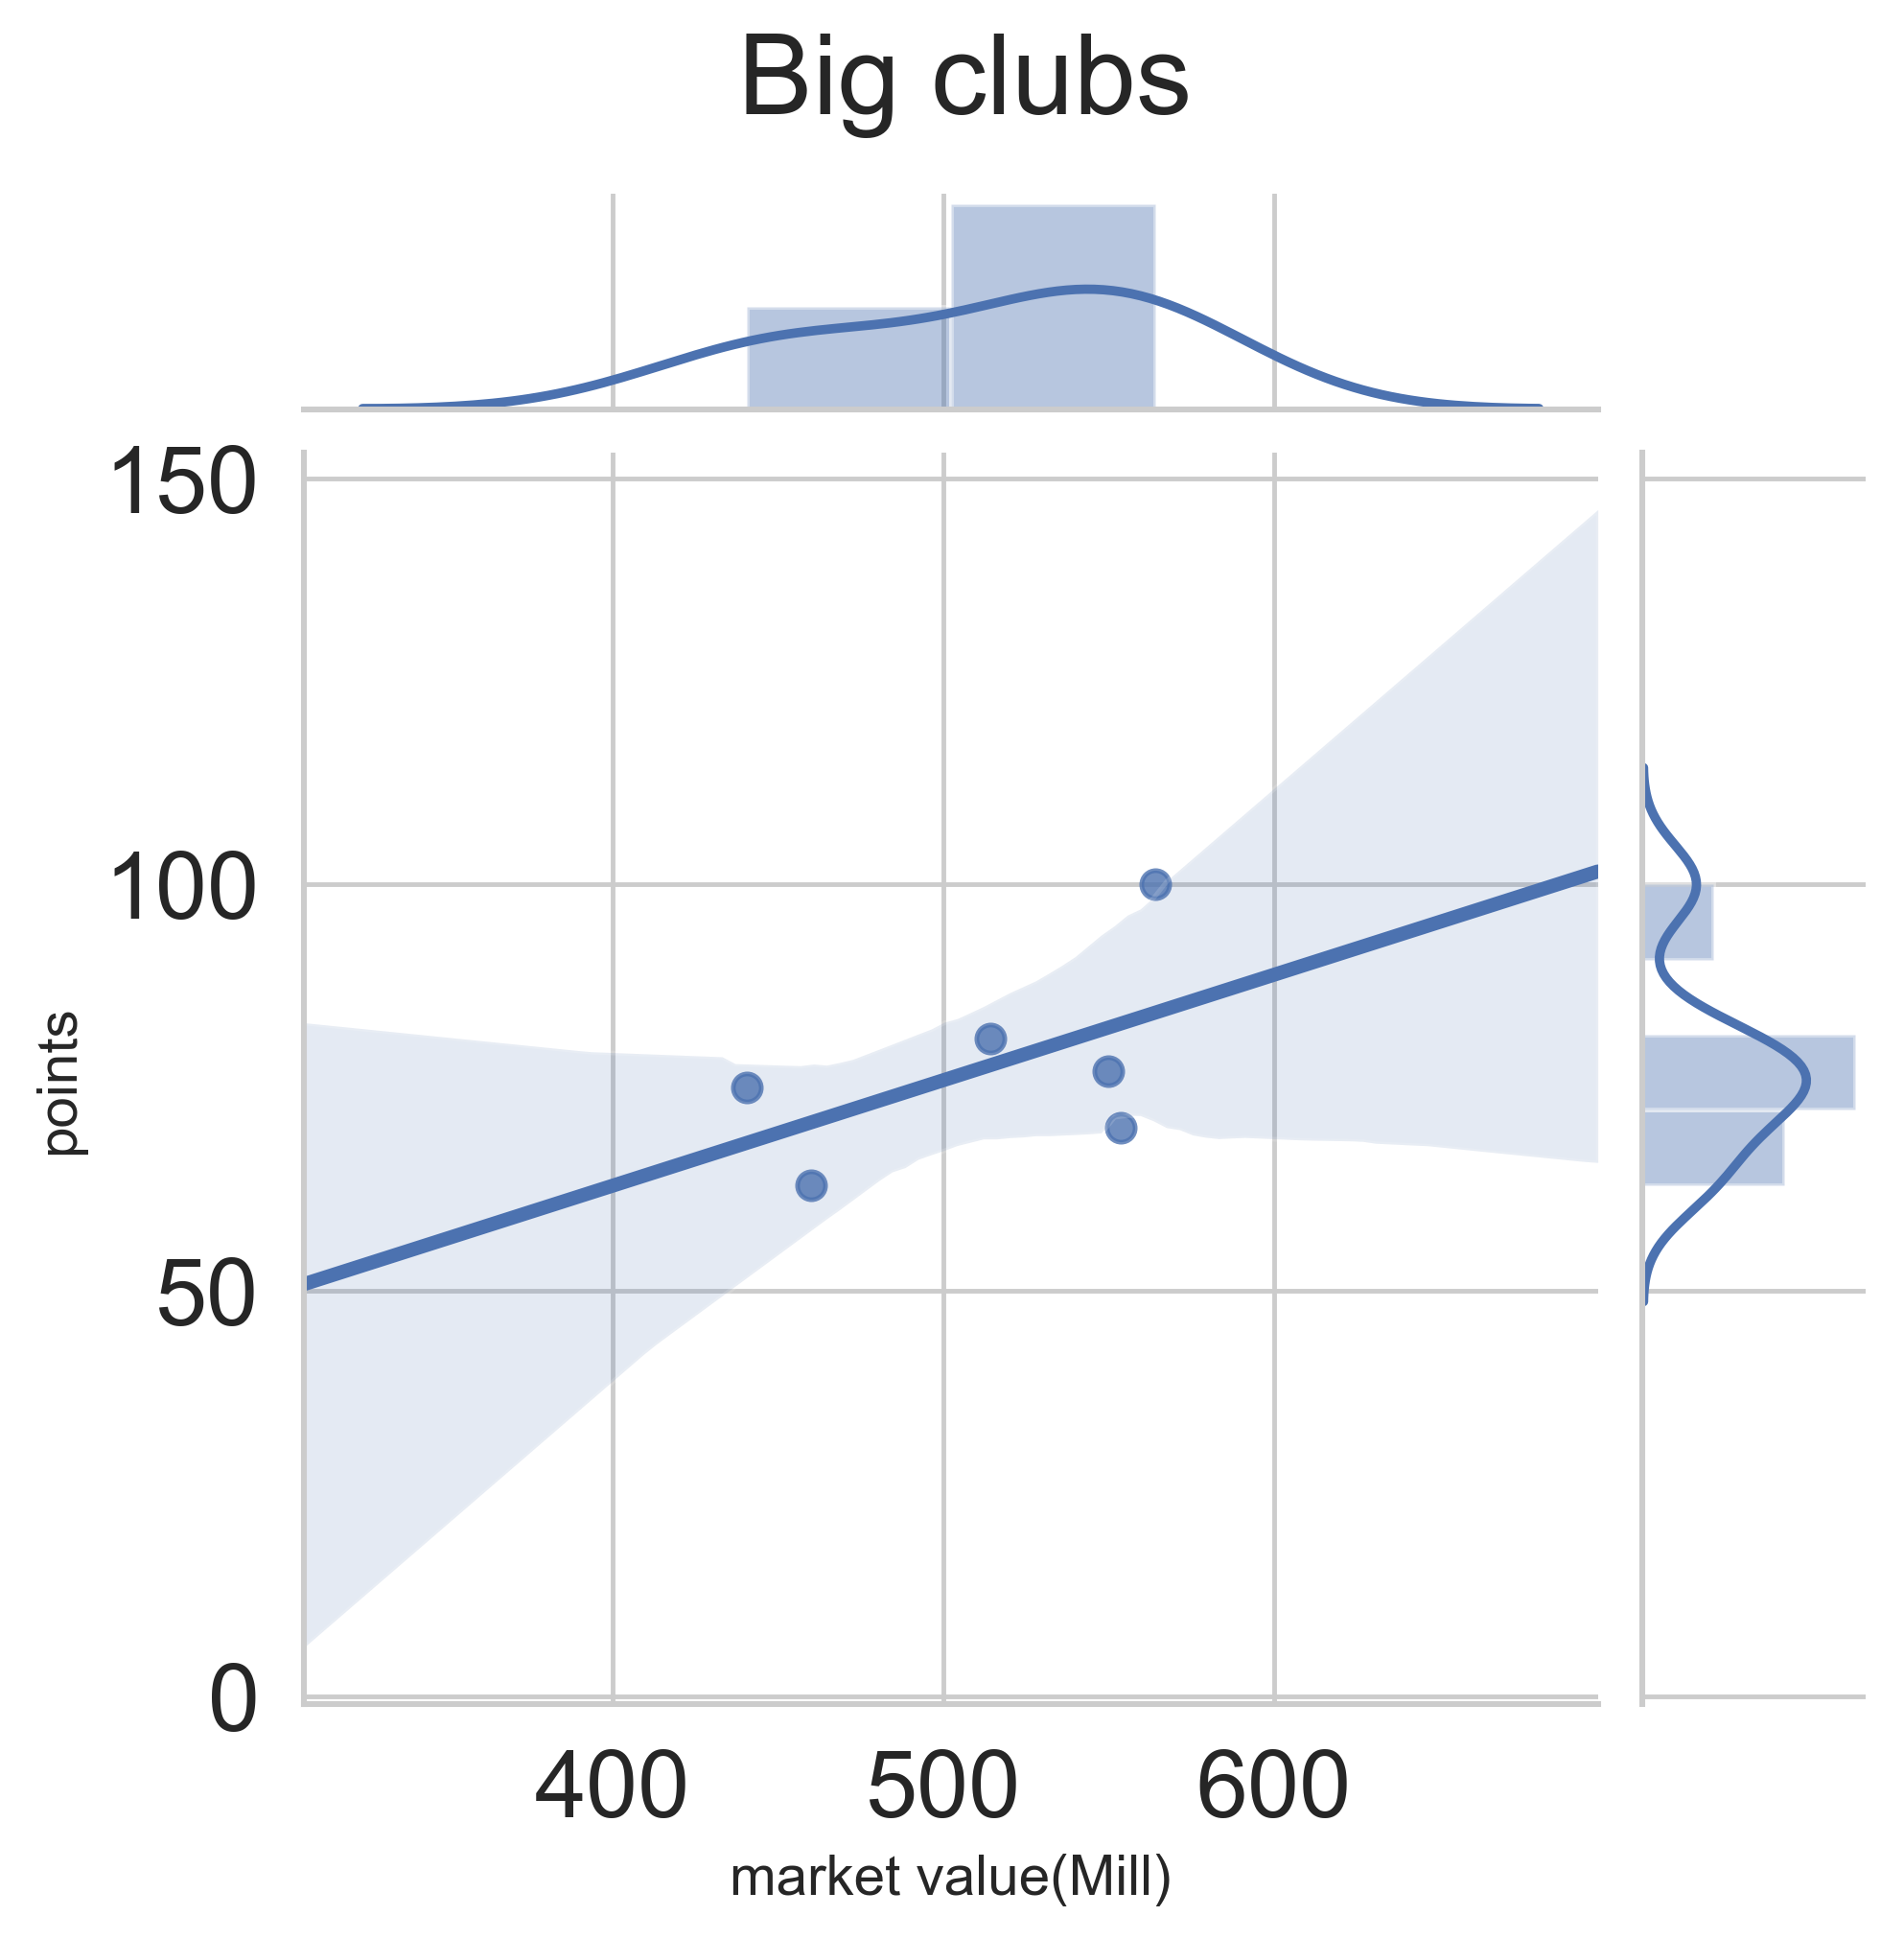

In [41]:

sns.jointplot(premier_league_df[premier_league_df["big club"] == True].groupby(["club"])["market value(Mill)"].sum().sort_values(ascending=False), pl_1718_table_df.set_index(keys="club").reindex(sorted_market_value_idx).loc[big_6_index, "points"], kind="reg")
plt.subplots_adjust(top=0.9)
plt.suptitle("Big clubs")

In [42]:
other_clubs_index = pl_1718_table_df.set_index(keys="club").reindex(sorted_market_value_idx).index[6:]

Text(0.5,0.98,'Small clubs')

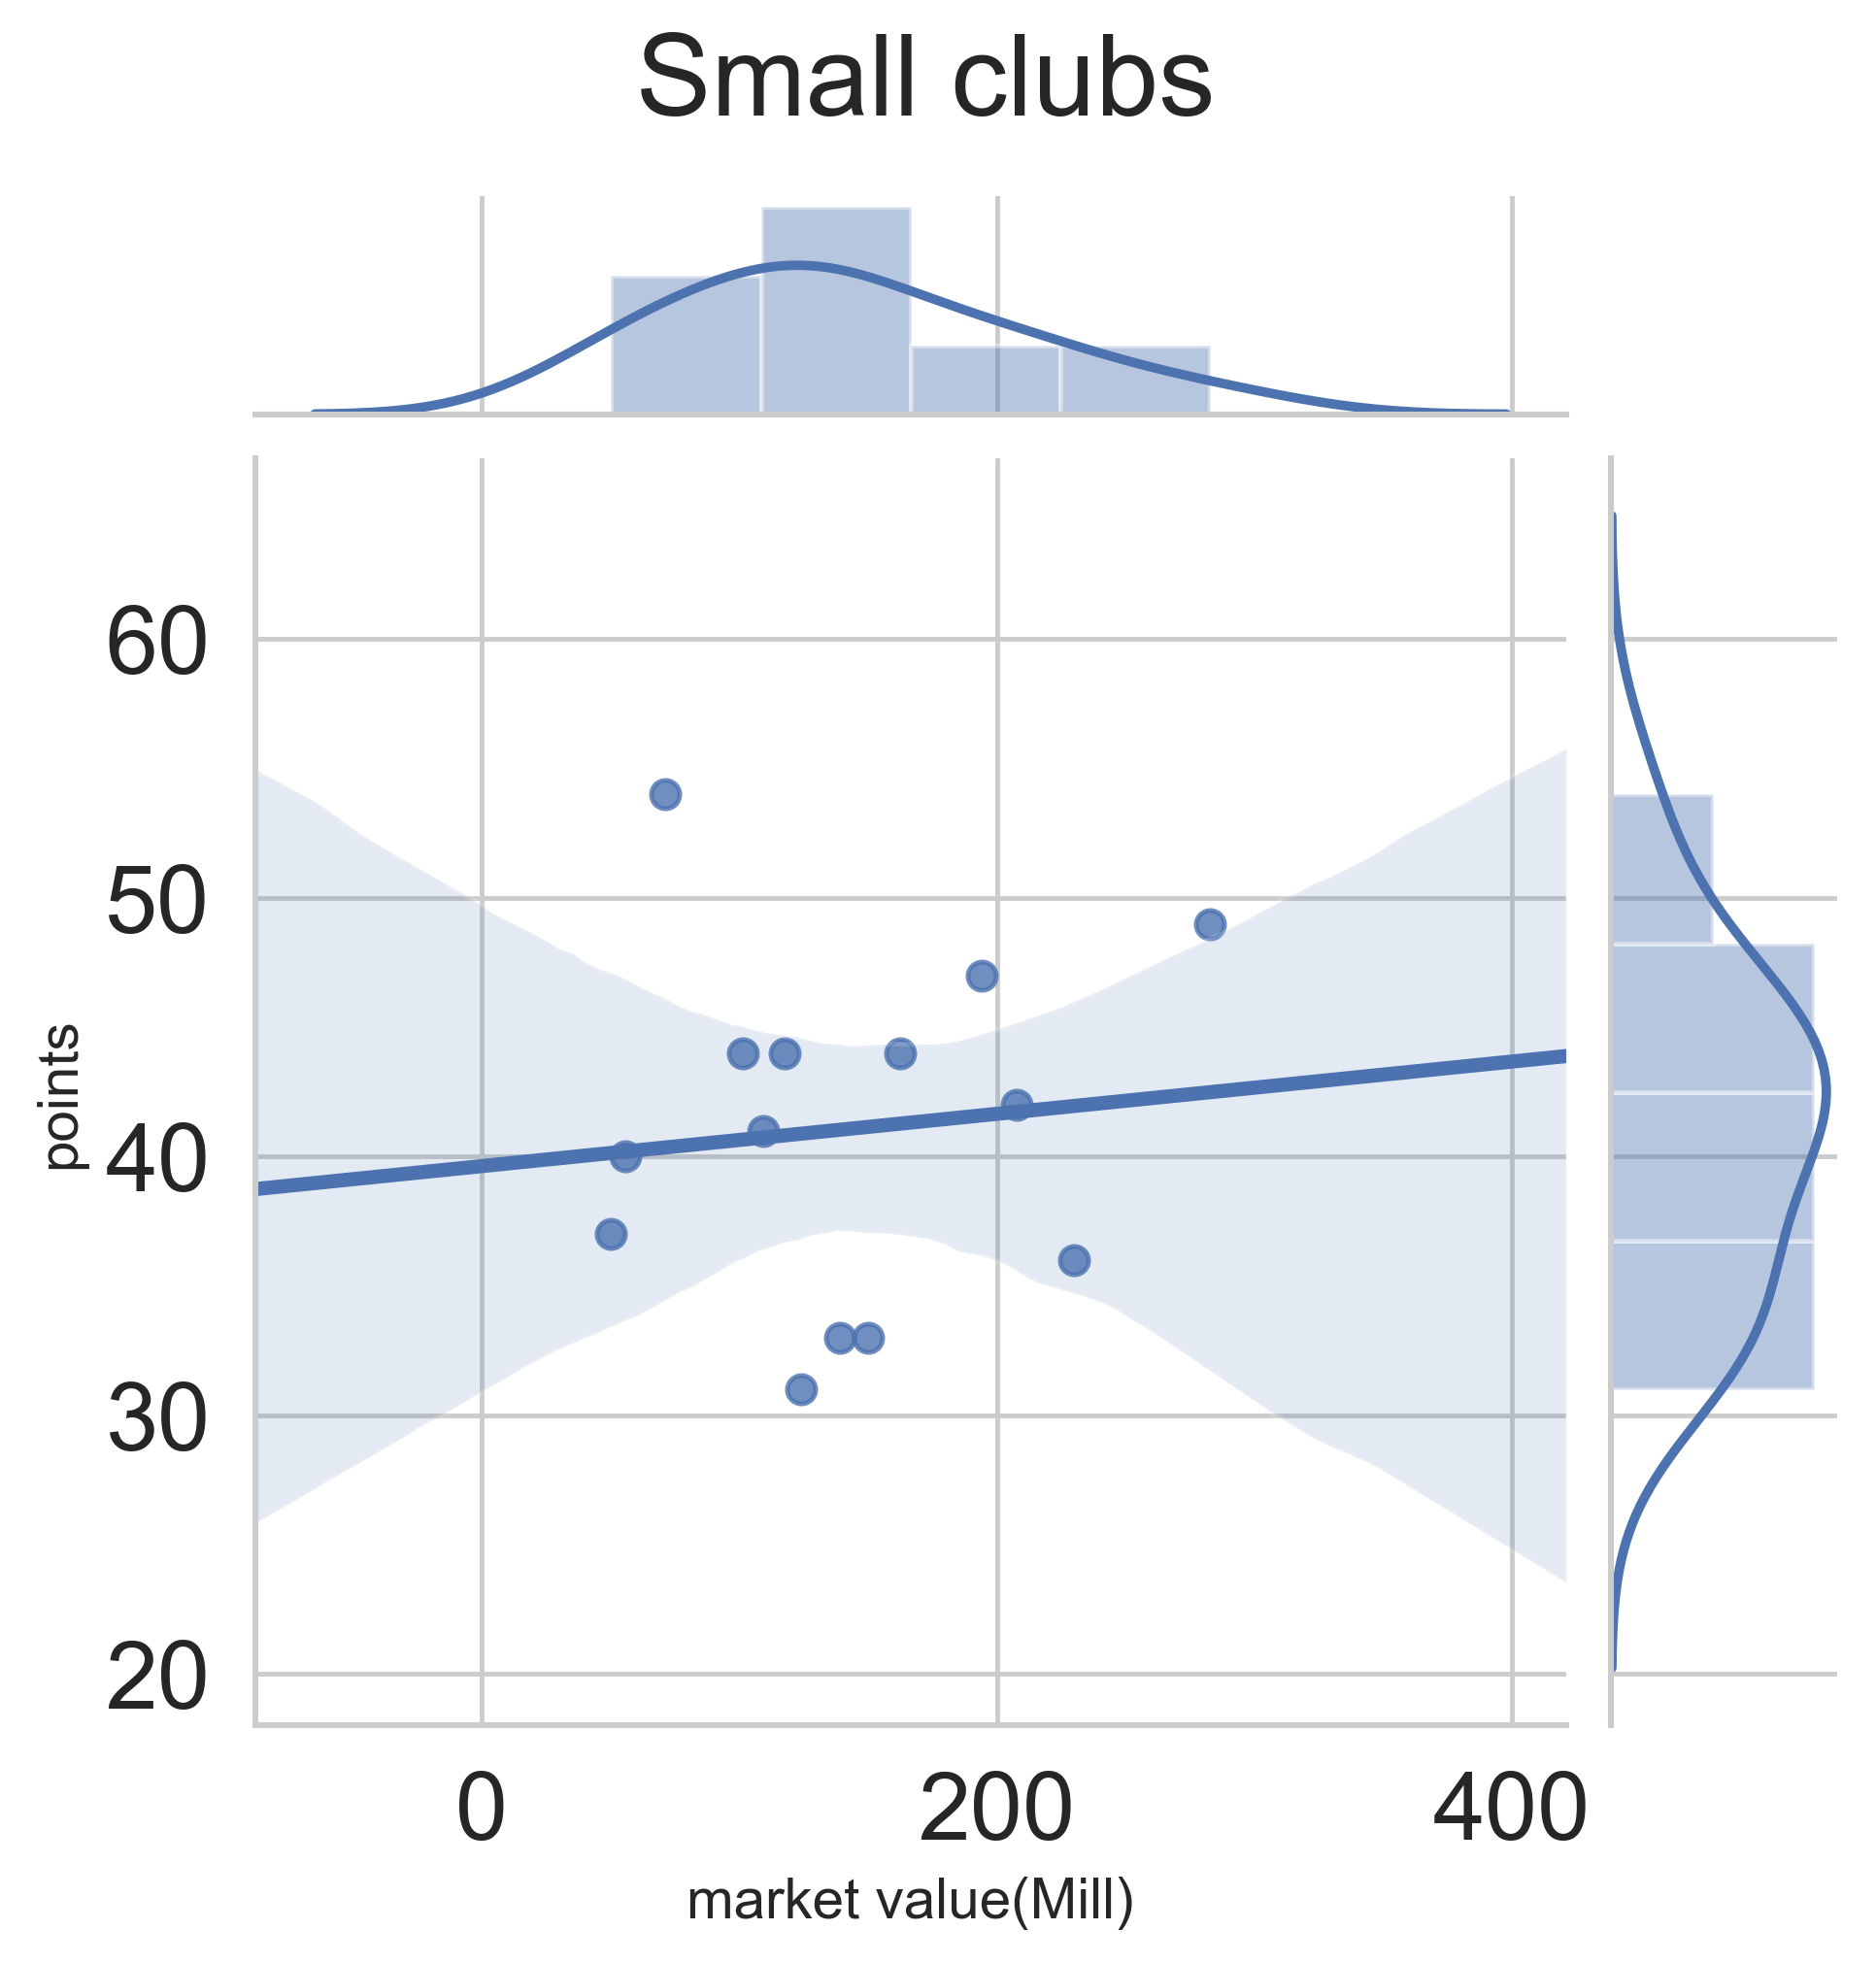

In [43]:
sns.jointplot(premier_league_df[premier_league_df["big club"] == False].groupby(["club"])["market value(Mill)"].sum().sort_values(ascending=False), pl_1718_table_df.set_index(keys="club").reindex(sorted_market_value_idx).loc[other_clubs_index, "points"], kind="reg")
plt.subplots_adjust(top=0.9)
plt.suptitle("Small clubs")

After the separation, the linear regression function becomes less confident. especially for the clubs that are not "big clubs", the relationship among them cannot described by a linear function.

### What do we know so far
1. The market values of a club can affect the standings of the club at the end of the season overall. 
2. However this effect is not a simple positive linear relationship especially when the market values sit in a particular group(if the club is the "big club"), the linear positive relationship becomes weak.

## Is the new signing player average market values a better evaluation?
---

New signing can represent the ambition of a club for new season. Even the portion of new signing doesn't affect the ranking of a club much, but we can check if the market values associated with new signing player a better estimation.

In [44]:
new_signing_df = premier_league_df[(premier_league_df["new signing"] == True) | (premier_league_df["new foreign"] == True)].groupby("club").mean().sort_values(by="market value(Mill)", ascending=False)[["market value(Mill)", "new signing", "age", "wiki views(daily)"]]

In [45]:
sorted_new_signing_index = new_signing_df.index
# Reorder the table by market valur
rank_se = pl_1718_table_df.set_index(keys="club").reindex(sorted_new_signing_index)["rank"]

In [46]:
new_signing_merge_df = pd.merge(new_signing_df.reset_index(), pl_1718_table_df, on="club").drop(["new signing", "played"], axis=1)

### Plotting the new signing multivariate data
---
Firstly plot the multivariate data to gain a big picture of the relationship between different features.

Text(0.5,0.98,'New Signing Players club average')

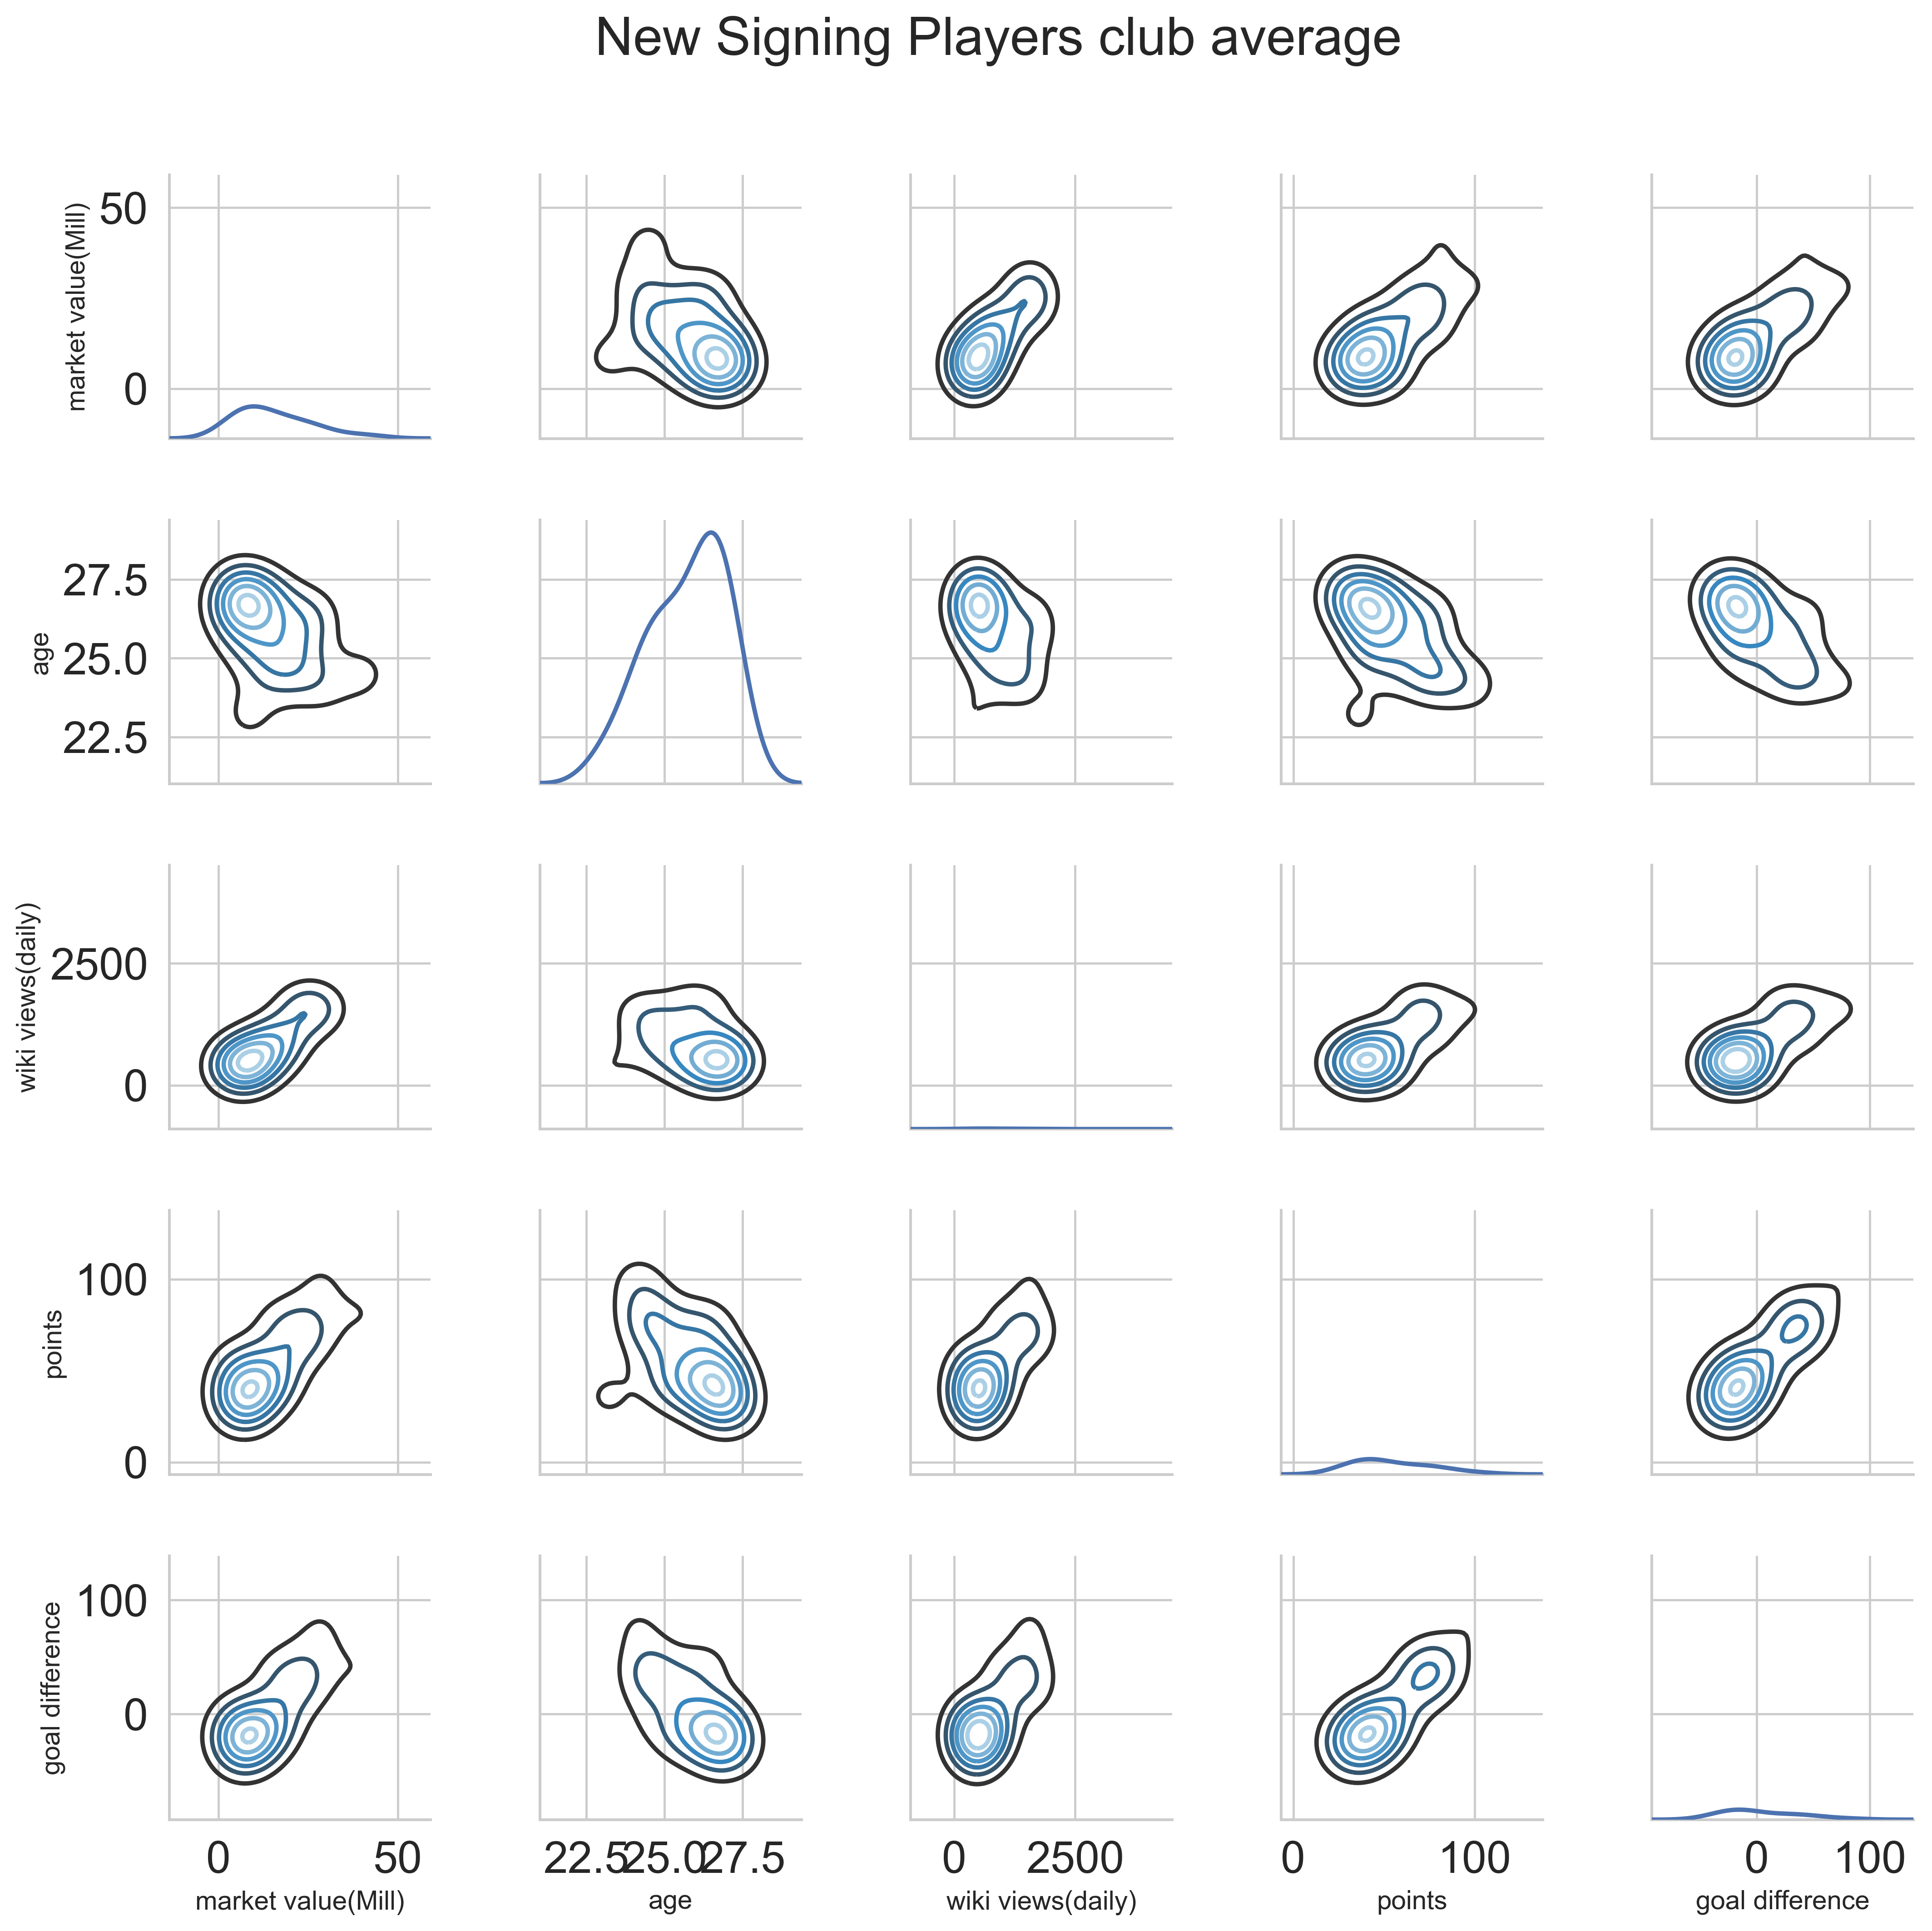

In [47]:
g = sns.PairGrid(new_signing_merge_df[["market value(Mill)", "age", "wiki views(daily)", "points", "goal difference"]])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)
plt.subplots_adjust(top=0.9)
plt.suptitle("New Signing Players club average")

From the above plot we can see couple of interesting facts:
* even as the age increasing the market value will drop, but the relationship is not that strong as we expected.
* The popularity of new signing player which reflected by their wikipedia page views, booming rapidly as their market values increasing.
* There is a strong positive relationship between goal difference and points a club gained at the end of season. The reason **Manchester City** reached a historical high points(100 points) is due to their surprising goal difference.

_Note: Goal difference is the difference between the goals and the goal against a club has_

In [48]:
new_signing_merge_df.corr().style.applymap(color_strong_corr_red)

Text(0.5,0.98,'New Signing Players')

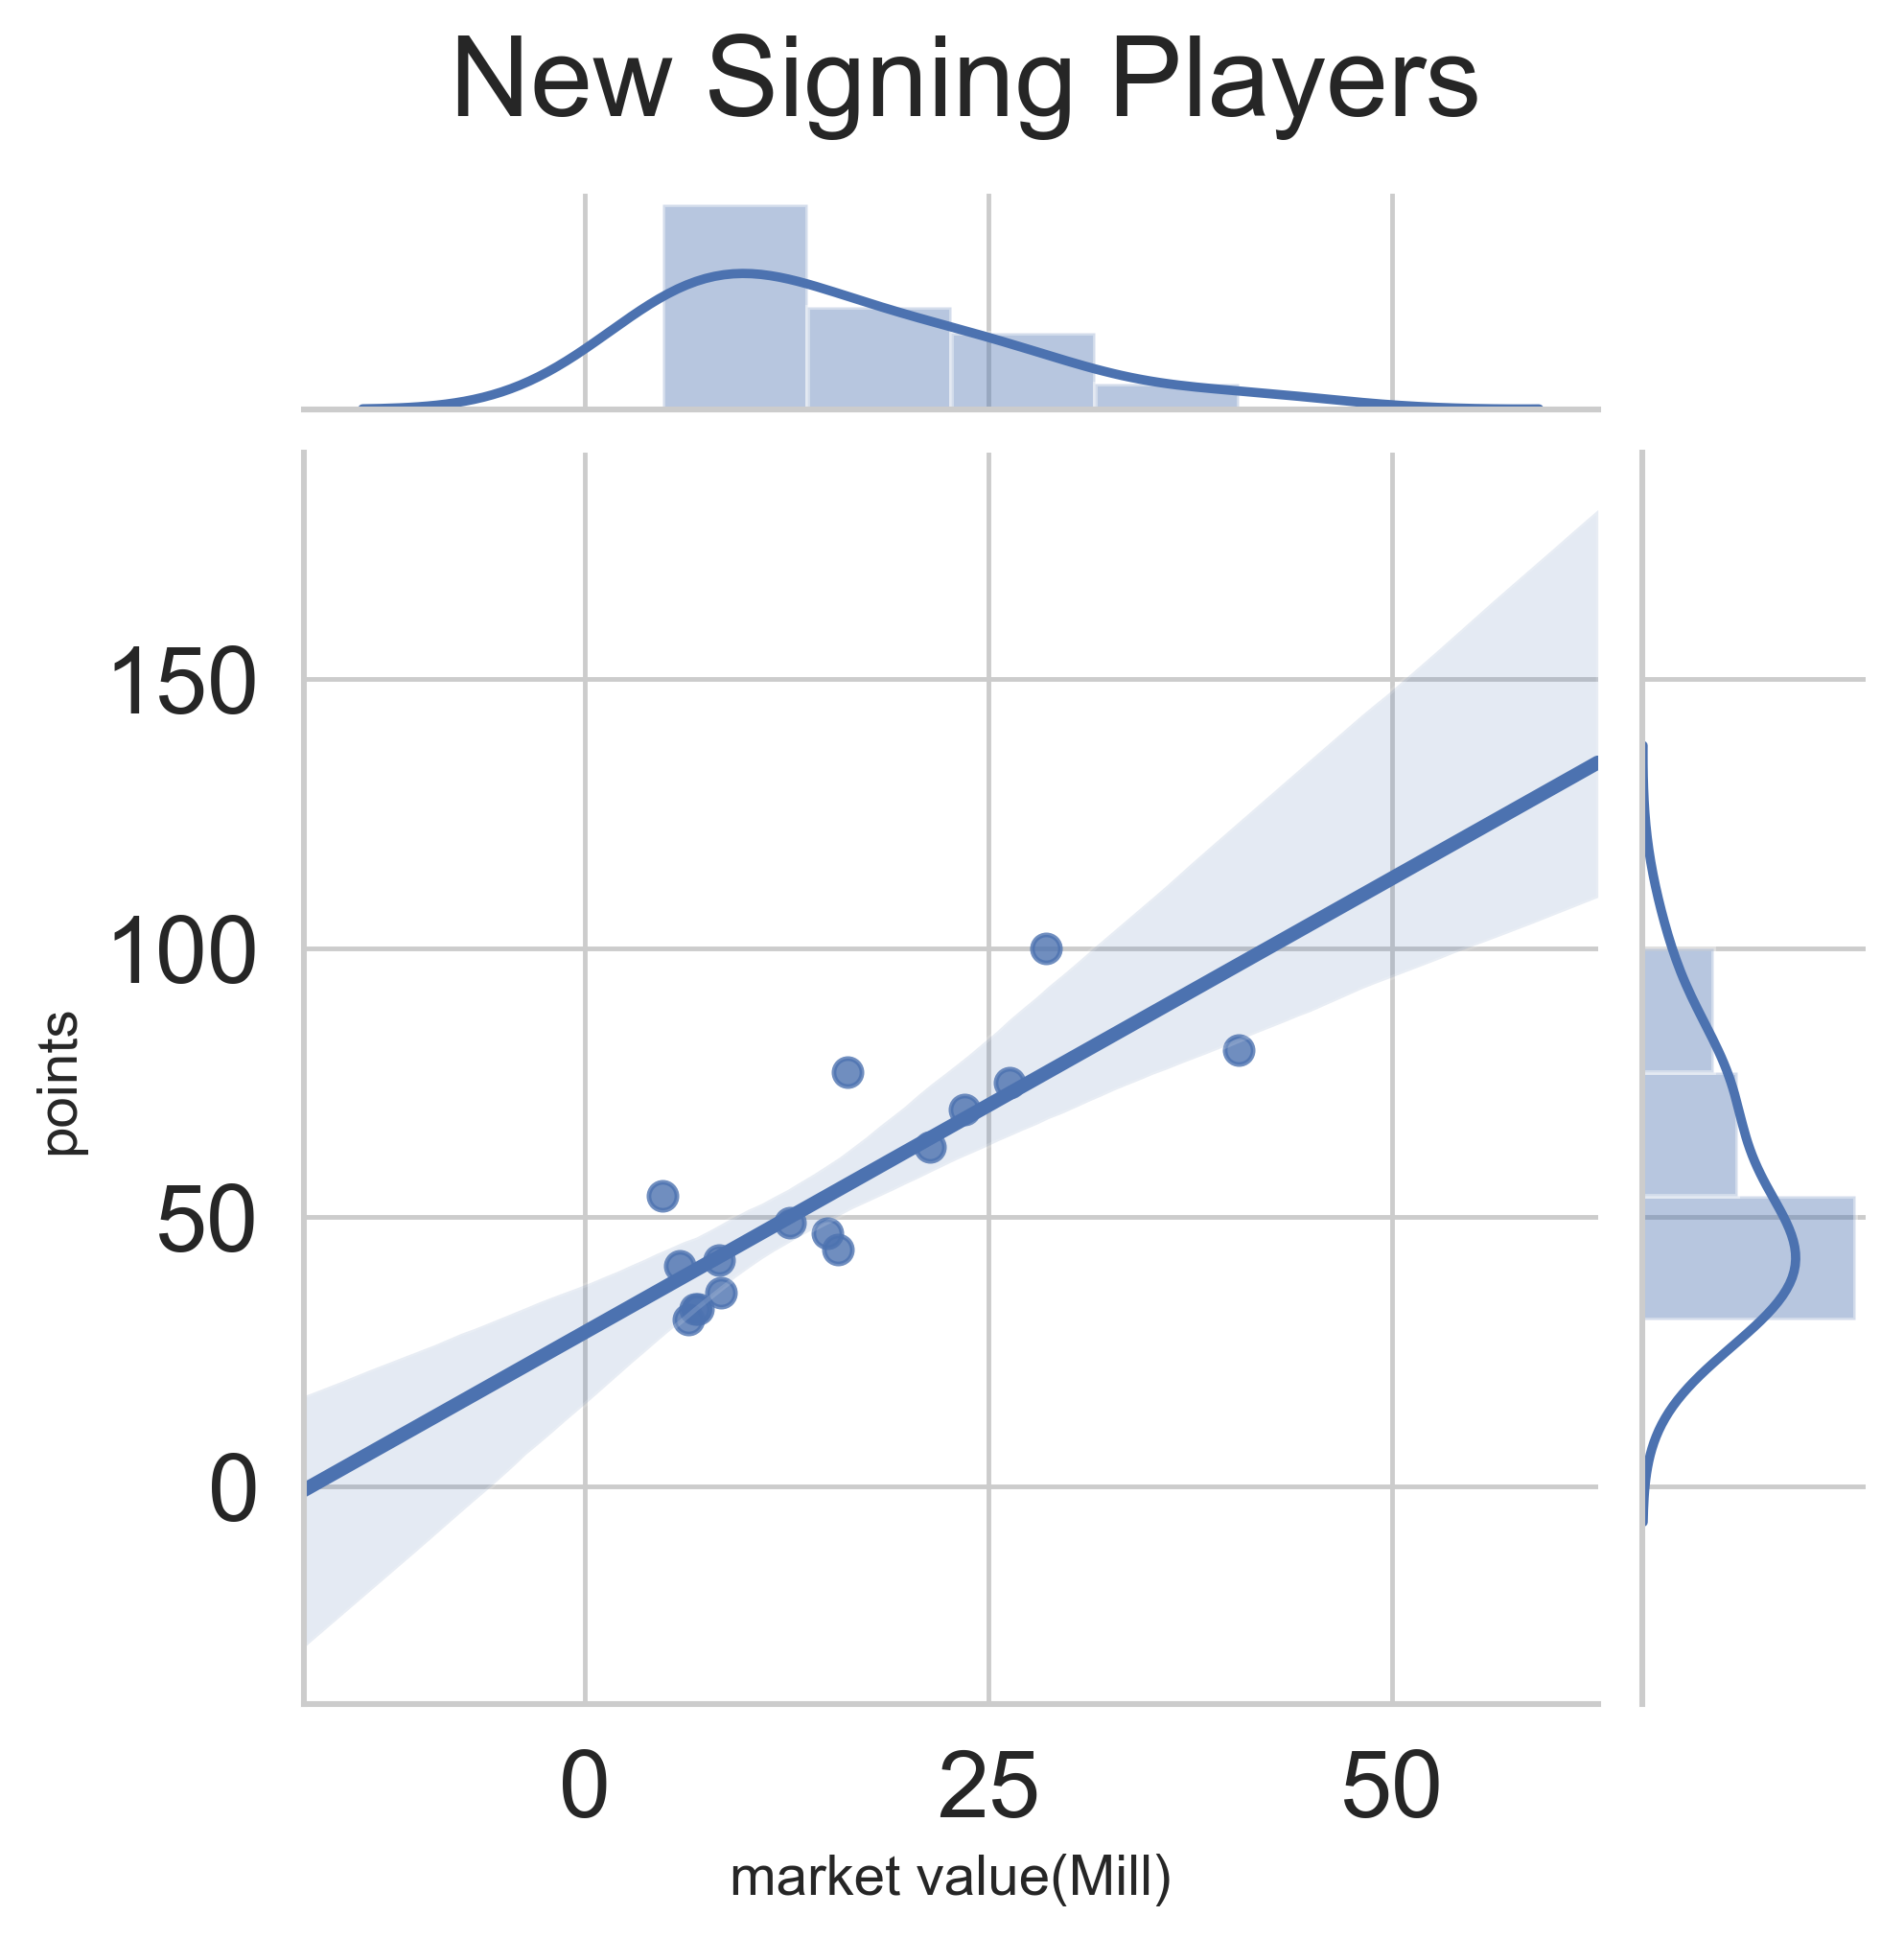

In [49]:
sns.jointplot(new_signing_df["market value(Mill)"], pl_1718_table_df.set_index(keys="club").reindex(sorted_new_signing_index)["points"], kind="reg")
# plt.title("The relation betweent new assigning investment and points")
plt.subplots_adjust(top=0.9)
plt.suptitle("New Signing Players")

Compared to the all players average market value a club has join plot with the points it gained, the new signing player average market value show a better linear relationship.

## Deeper relationship among the age the value and the points
---

Text(0.5,0.98,'Big clubs age distribution over position')

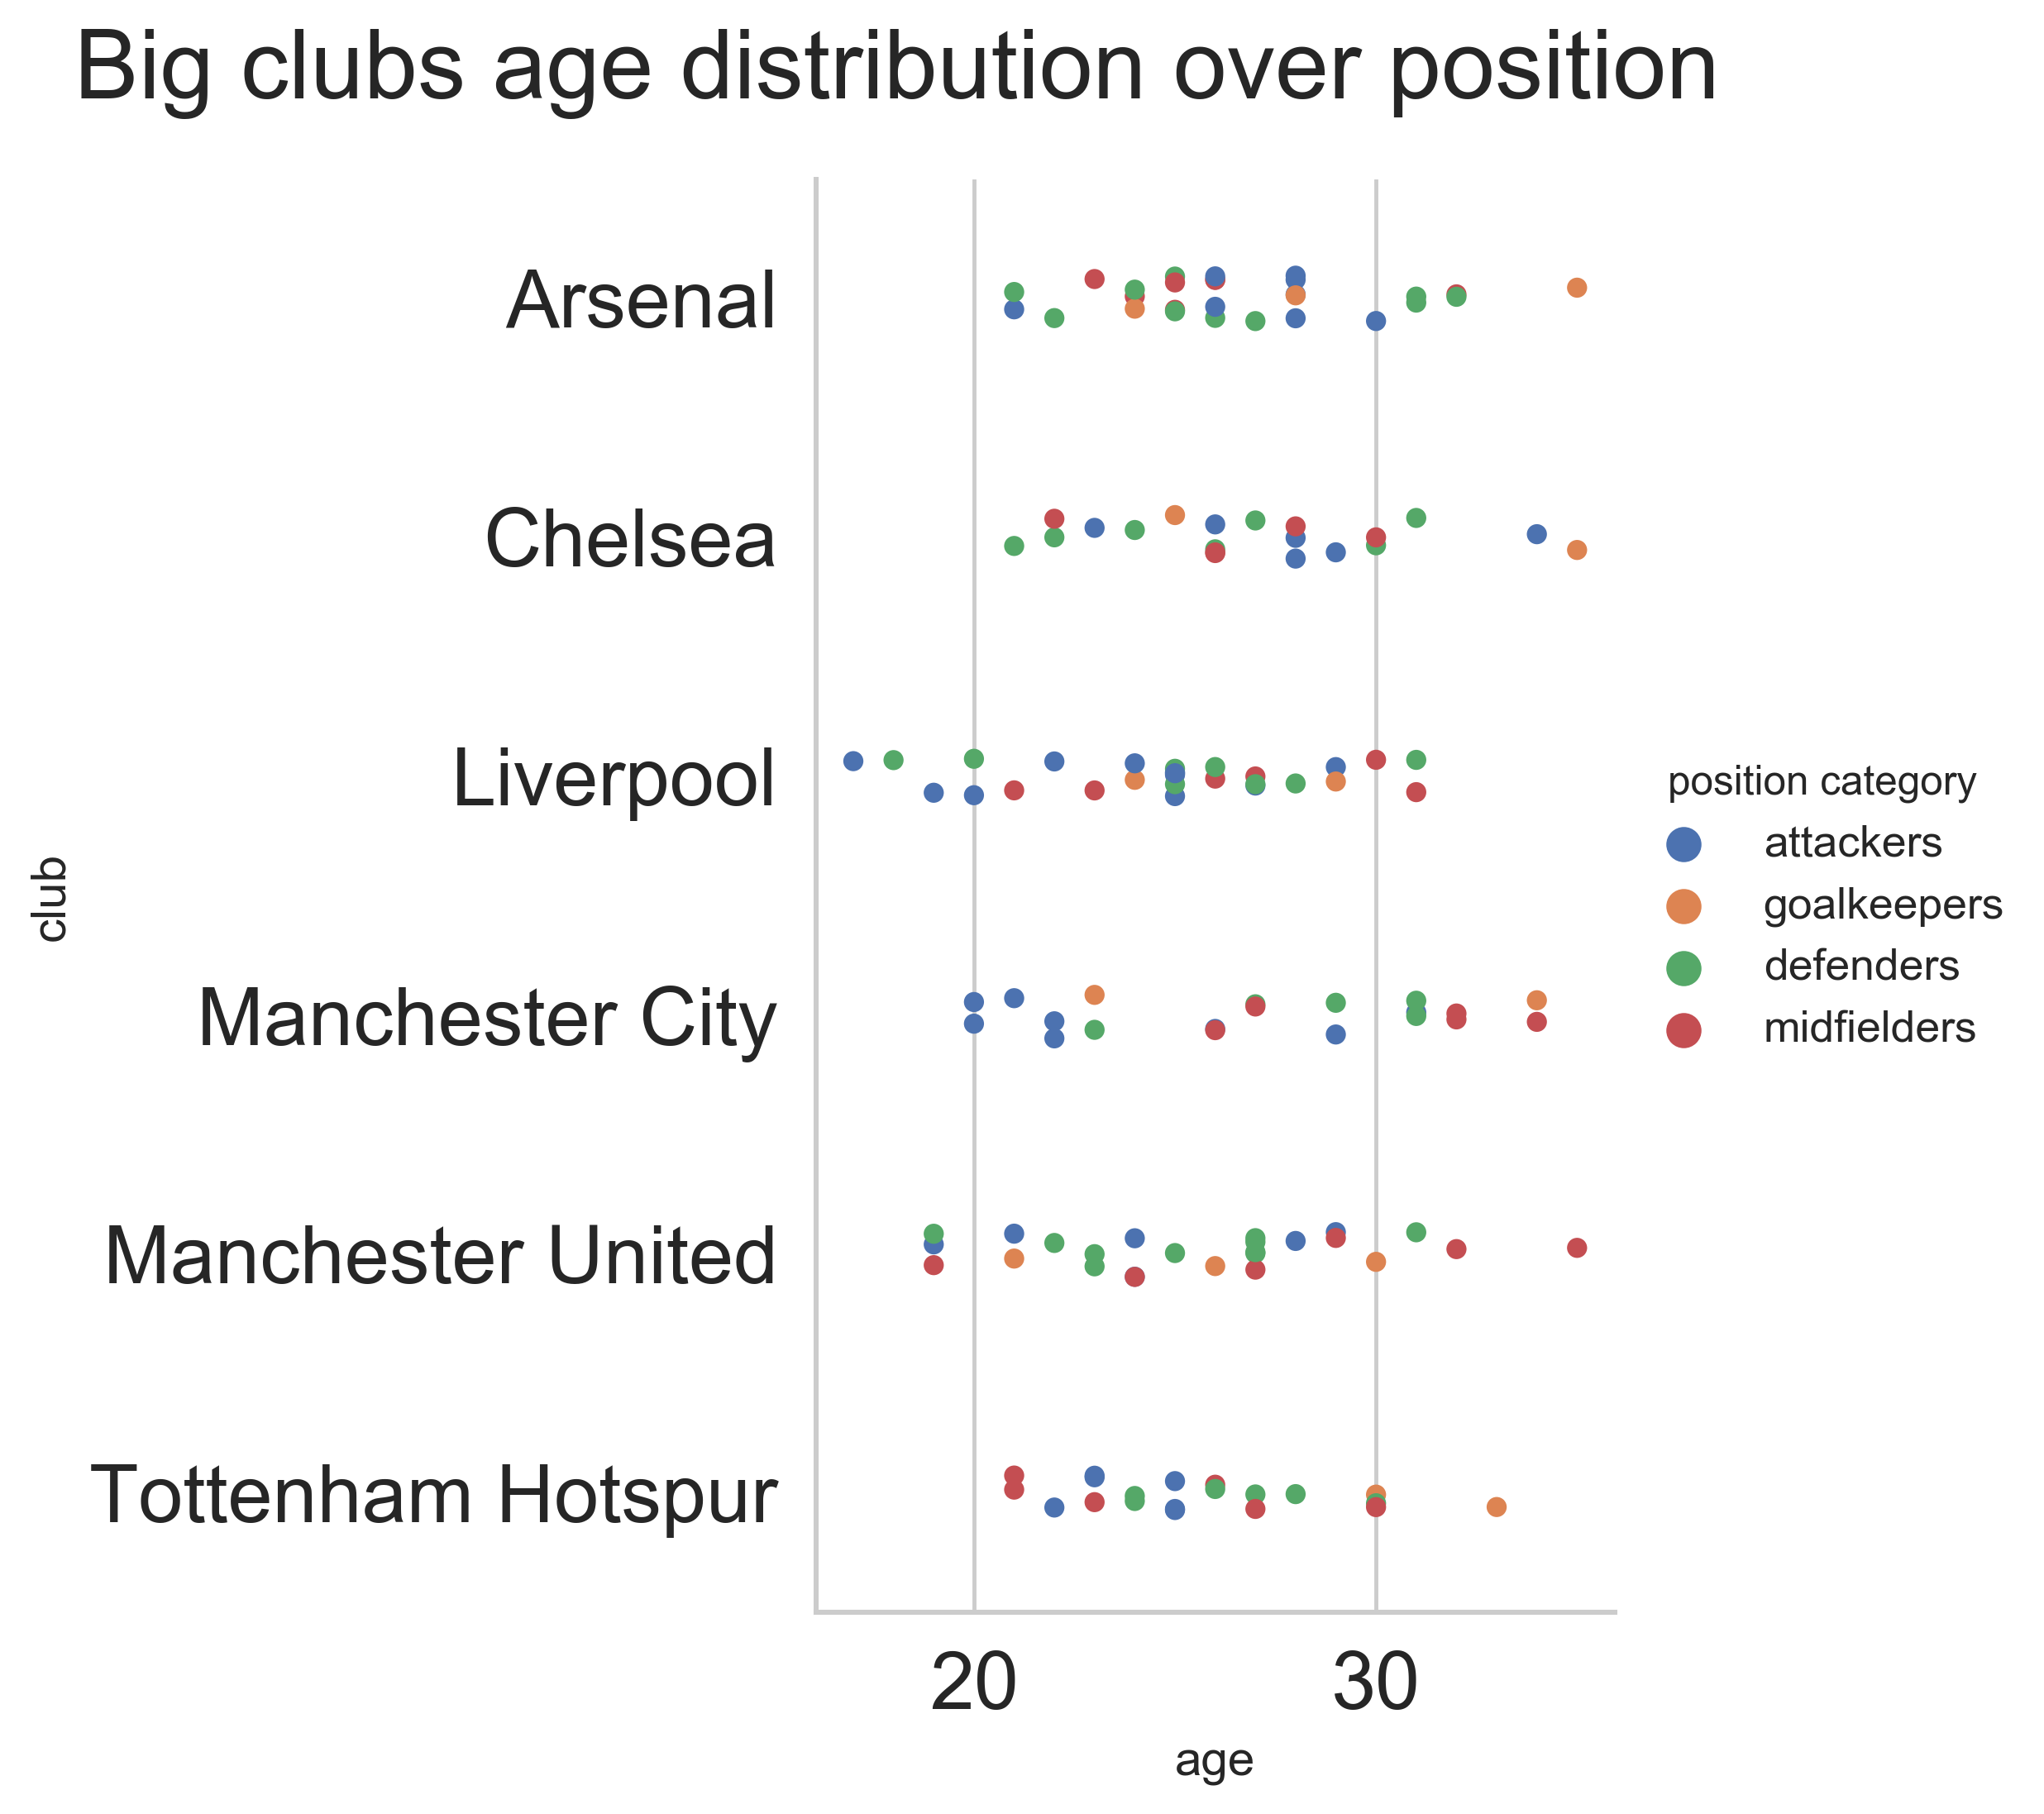

In [50]:
sns.catplot(x="age", y="club", data=premier_league_df[premier_league_df["big club"] == True], hue="position category", height=6.5)
plt.subplots_adjust(top=0.9)
plt.suptitle("Big clubs age distribution over position")


* **Liverpool** has many young players, which give the Liverpool the potential of future mark values. As the positive relationship between market values and the standings of a club, **Liverpool** is likely to have a good rank in the future premier league.
* Another interesting fact that is Liverpool, hotspur and manchester city all have young attackers. Is there a relationship between the average age of attackers and the total goals the club score.

In [51]:
attacker_average_df = premier_league_df[premier_league_df["position category"] == "attackers"].groupby("club").mean().sort_values("age")

In [52]:
attacker_average_merge_df = pd.merge(attacker_average_df, pl_1718_table_df, on="club").drop(["fpl value", "fpl points", "new foreign", "new signing", "played"], axis=1)

It is obviously that the age will not be the only factor that affects goals. A new factor that combine the age and the market values should be introduced.

In [53]:
attacker_average_merge_df["value/age"] = attacker_average_merge_df["market value(Mill)"]/ np.square(attacker_average_merge_df["age"])

In [54]:
def color_very_strong_corr_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for strong correlations
    , black otherwise.
    """
    color = 'red' if (val > 0.9 or val < -0.9)  else 'black'
    return 'color: %s' % color

In [55]:
attacker_average_merge_df[["club", "age", "value/age", "market value(Mill)", "big club", "goals", "points"]].corr().style.applymap(color_very_strong_corr_red)

From the correlation table, we can see that, as we expected, the combination of value and age feature has a strong relationship to goals. Even more surprisingly we see a even stronger correlation with the points!

Text(0.5,0.98,'All clubs')

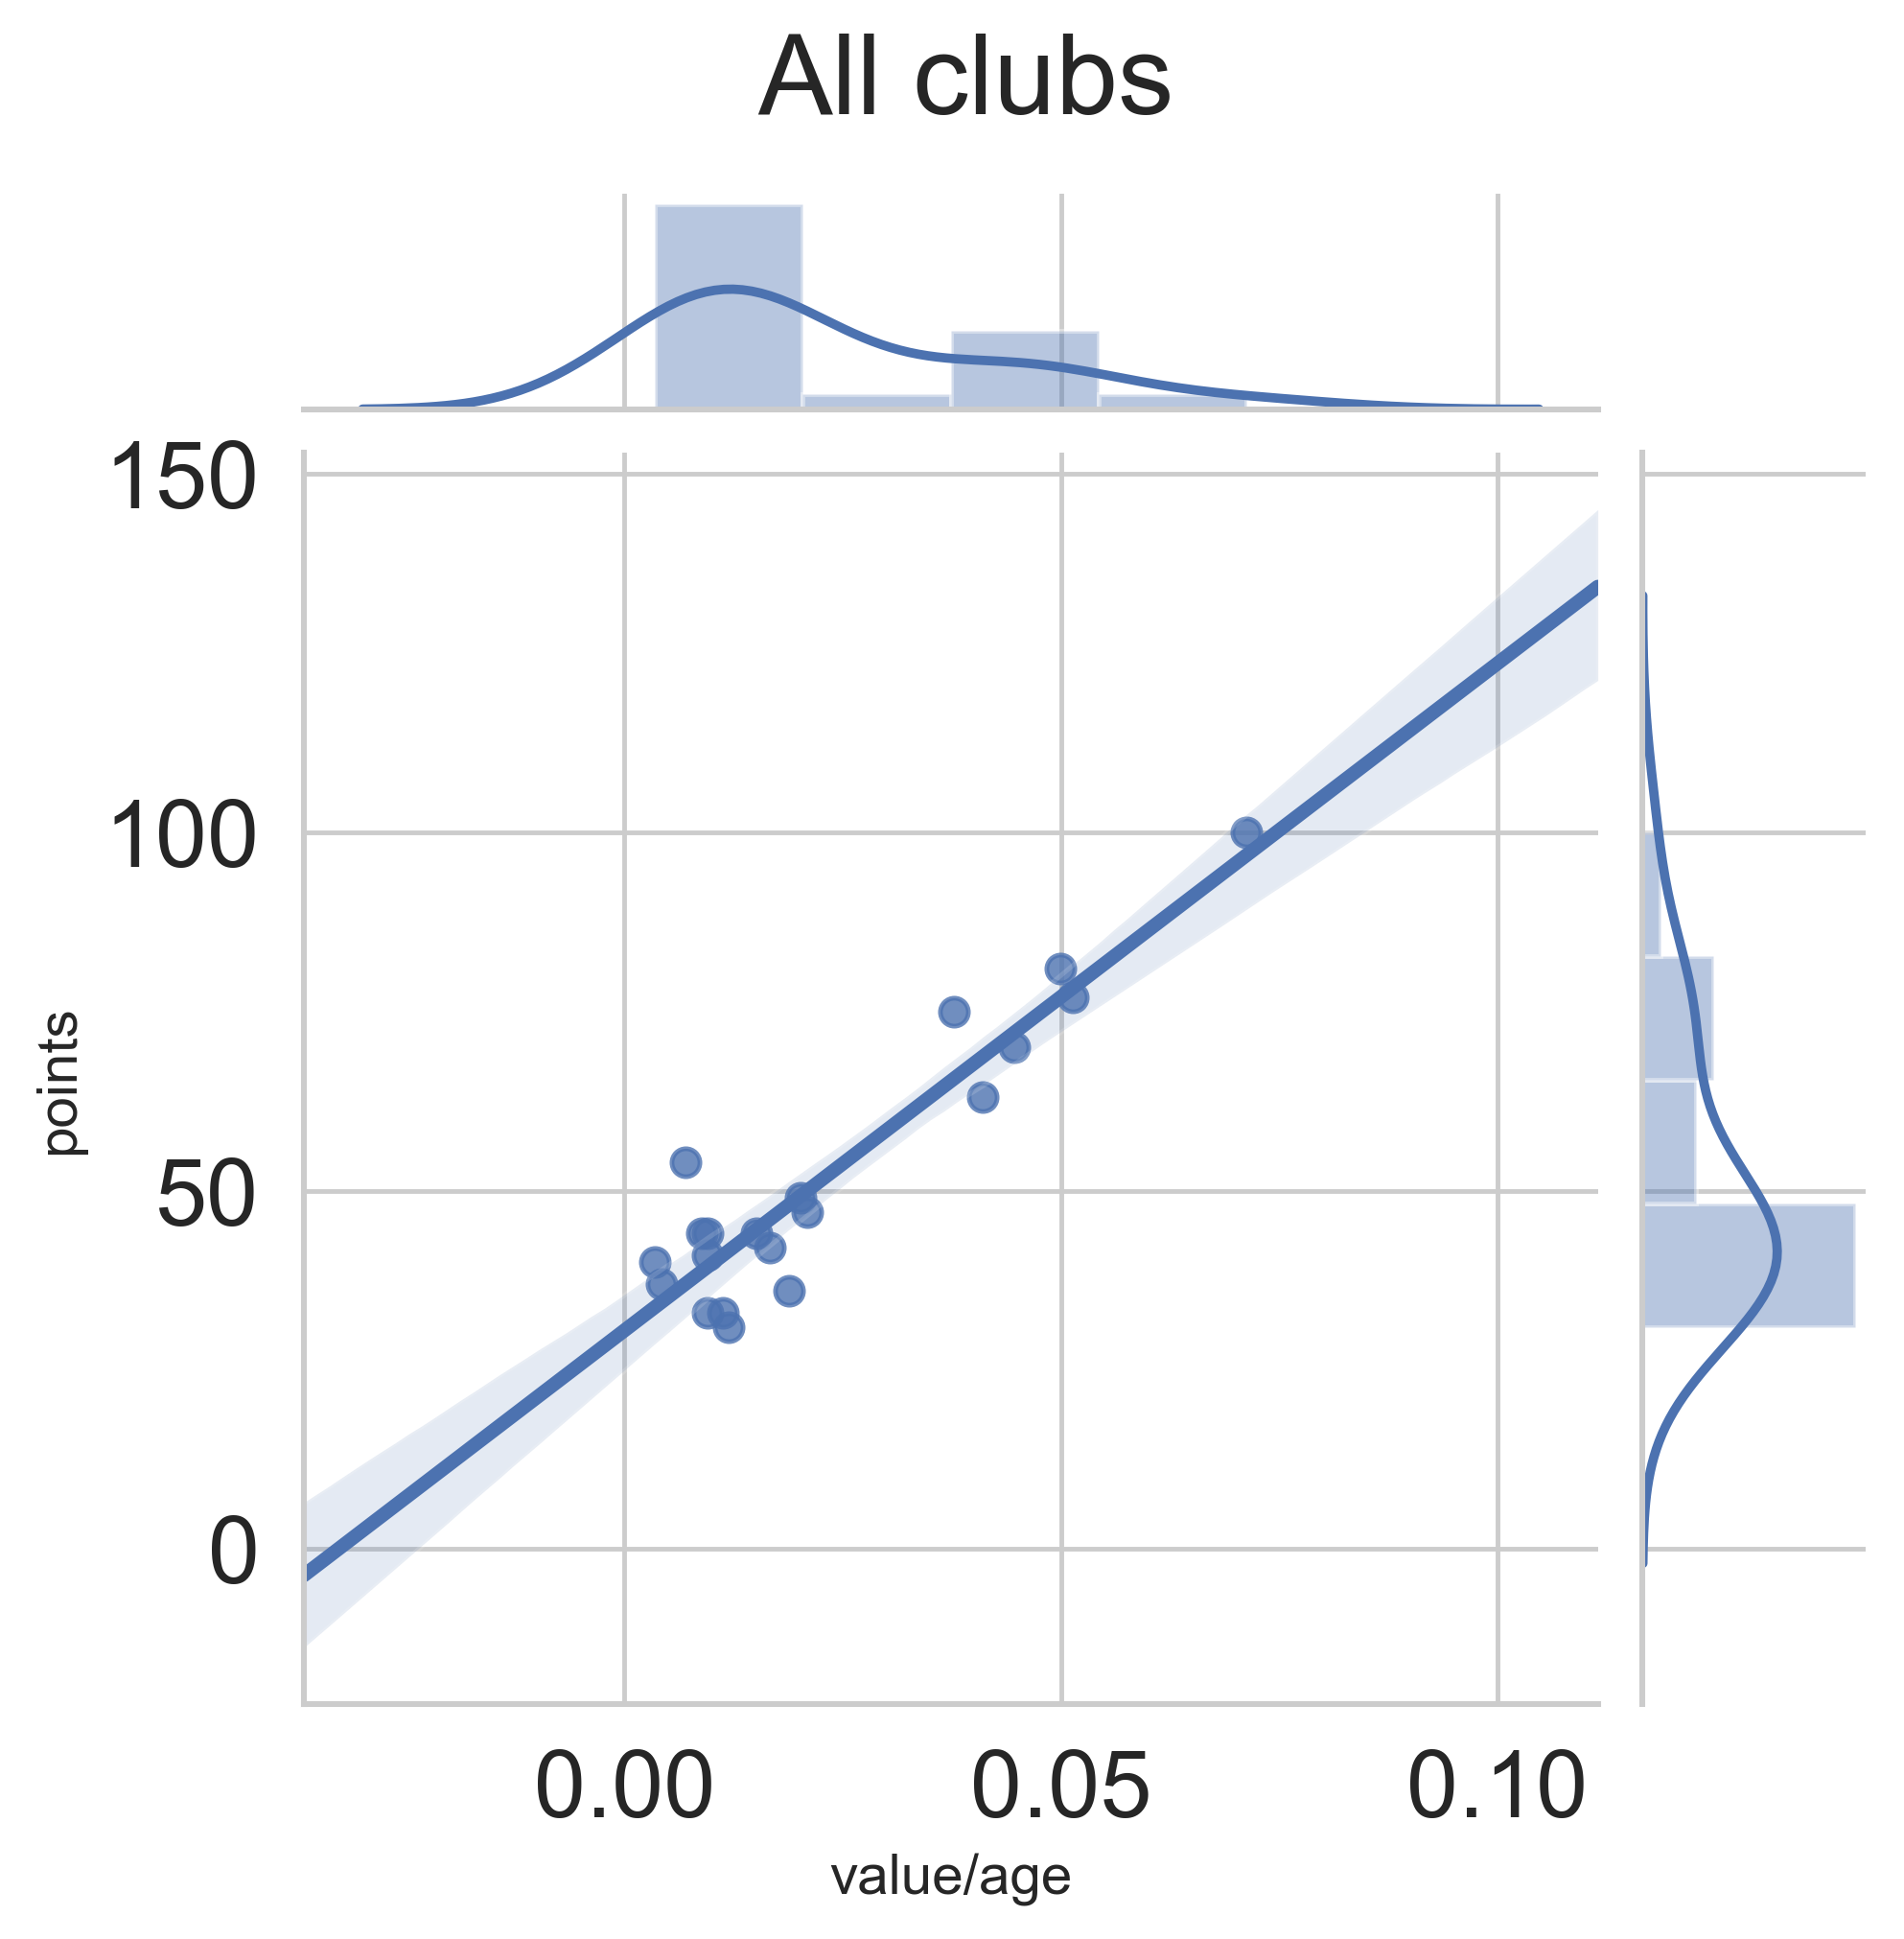

In [56]:
sns.jointplot(attacker_average_merge_df["value/age"], attacker_average_merge_df["points"], kind="reg")
plt.subplots_adjust(top=0.9)
plt.suptitle("All clubs")

Text(0.5,0.98,'All clubs')

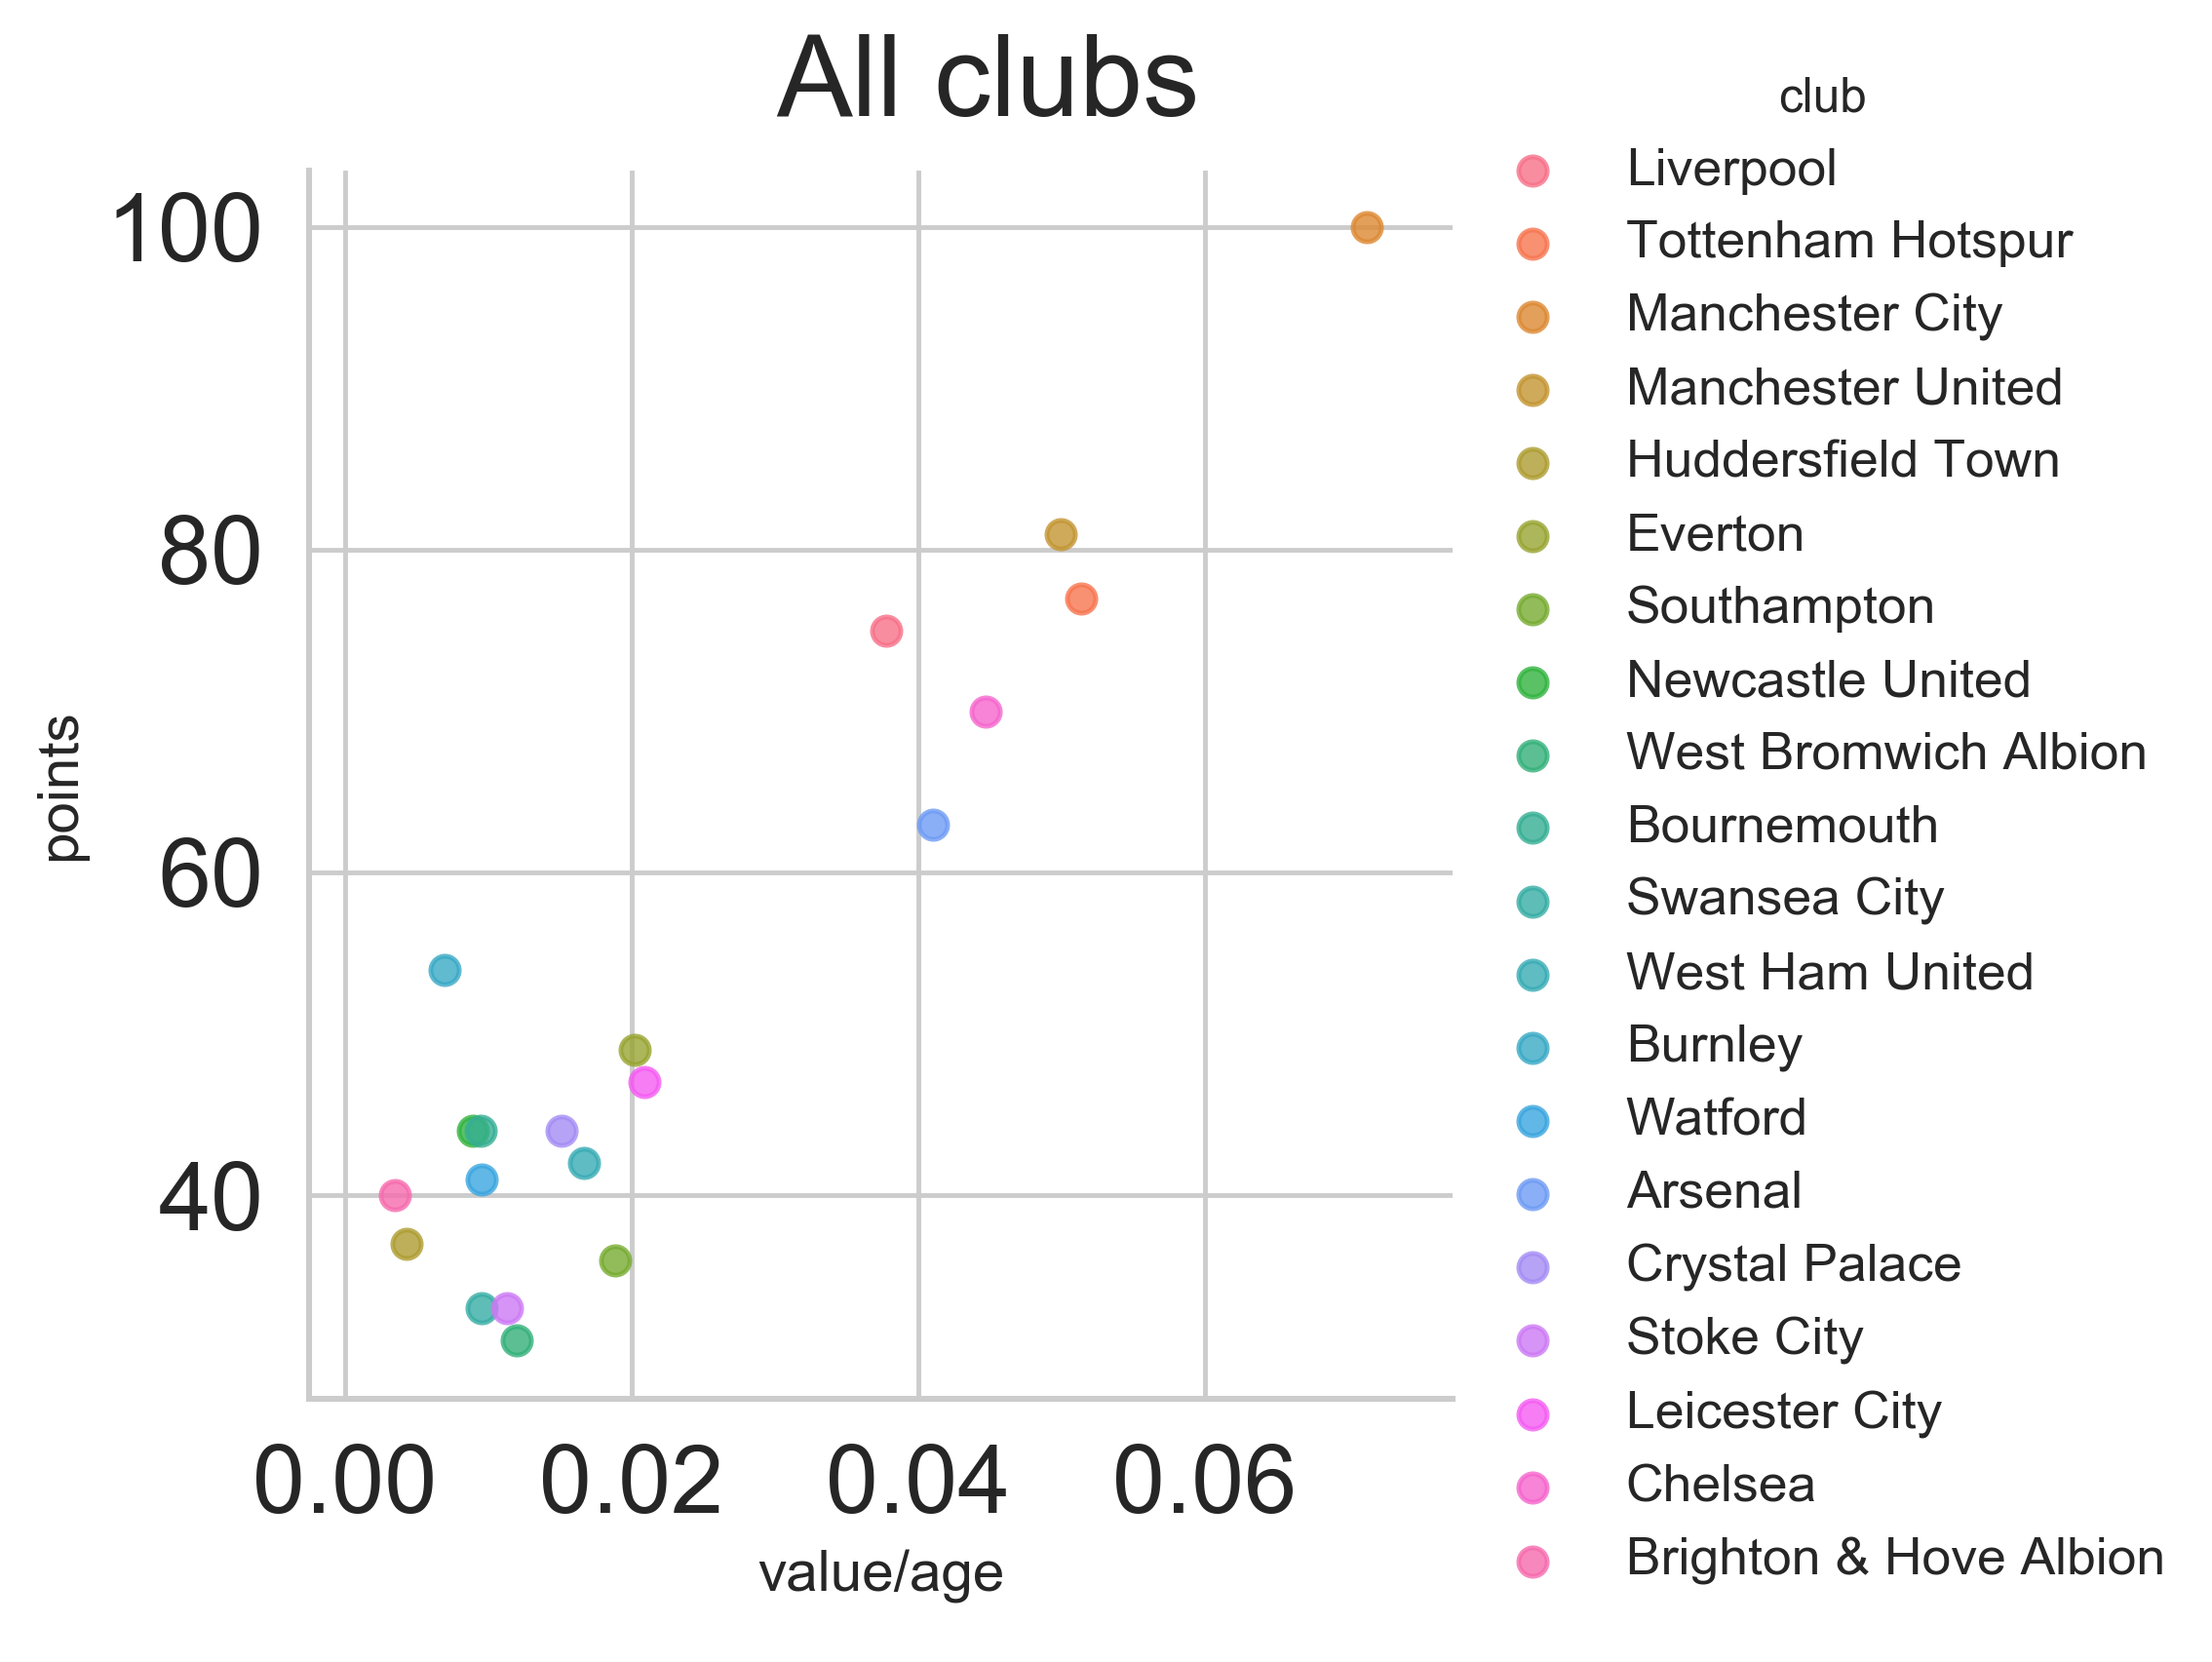

In [57]:
sns.lmplot(x="value/age", y="points", data=attacker_average_merge_df, hue="club", fit_reg=False)
plt.subplots_adjust(top=0.9)
plt.suptitle("All clubs")

### What do we know so far:
1. The clubs are divided into three groups, the **Manchester City** had a extremely successful season reflected by the surprising 100 points at the end of the season.
2. The reason behind its great season is that, attackers of **Manchester City** have the best $\frac{market value(Mill)}{ (age)^2}$, which means they are young and well performance.

## _Side Project: Fortune and Fame_
---
Is the market value normally distributed among all the position in the premier league. Which position is the most popular one and which position is dying?

<img src="source/association_football_position.png" width=400>

In [58]:
position_mean_order_idx = premier_league_df.groupby("position").mean().sort_values("market value(Mill)", ascending=False).index

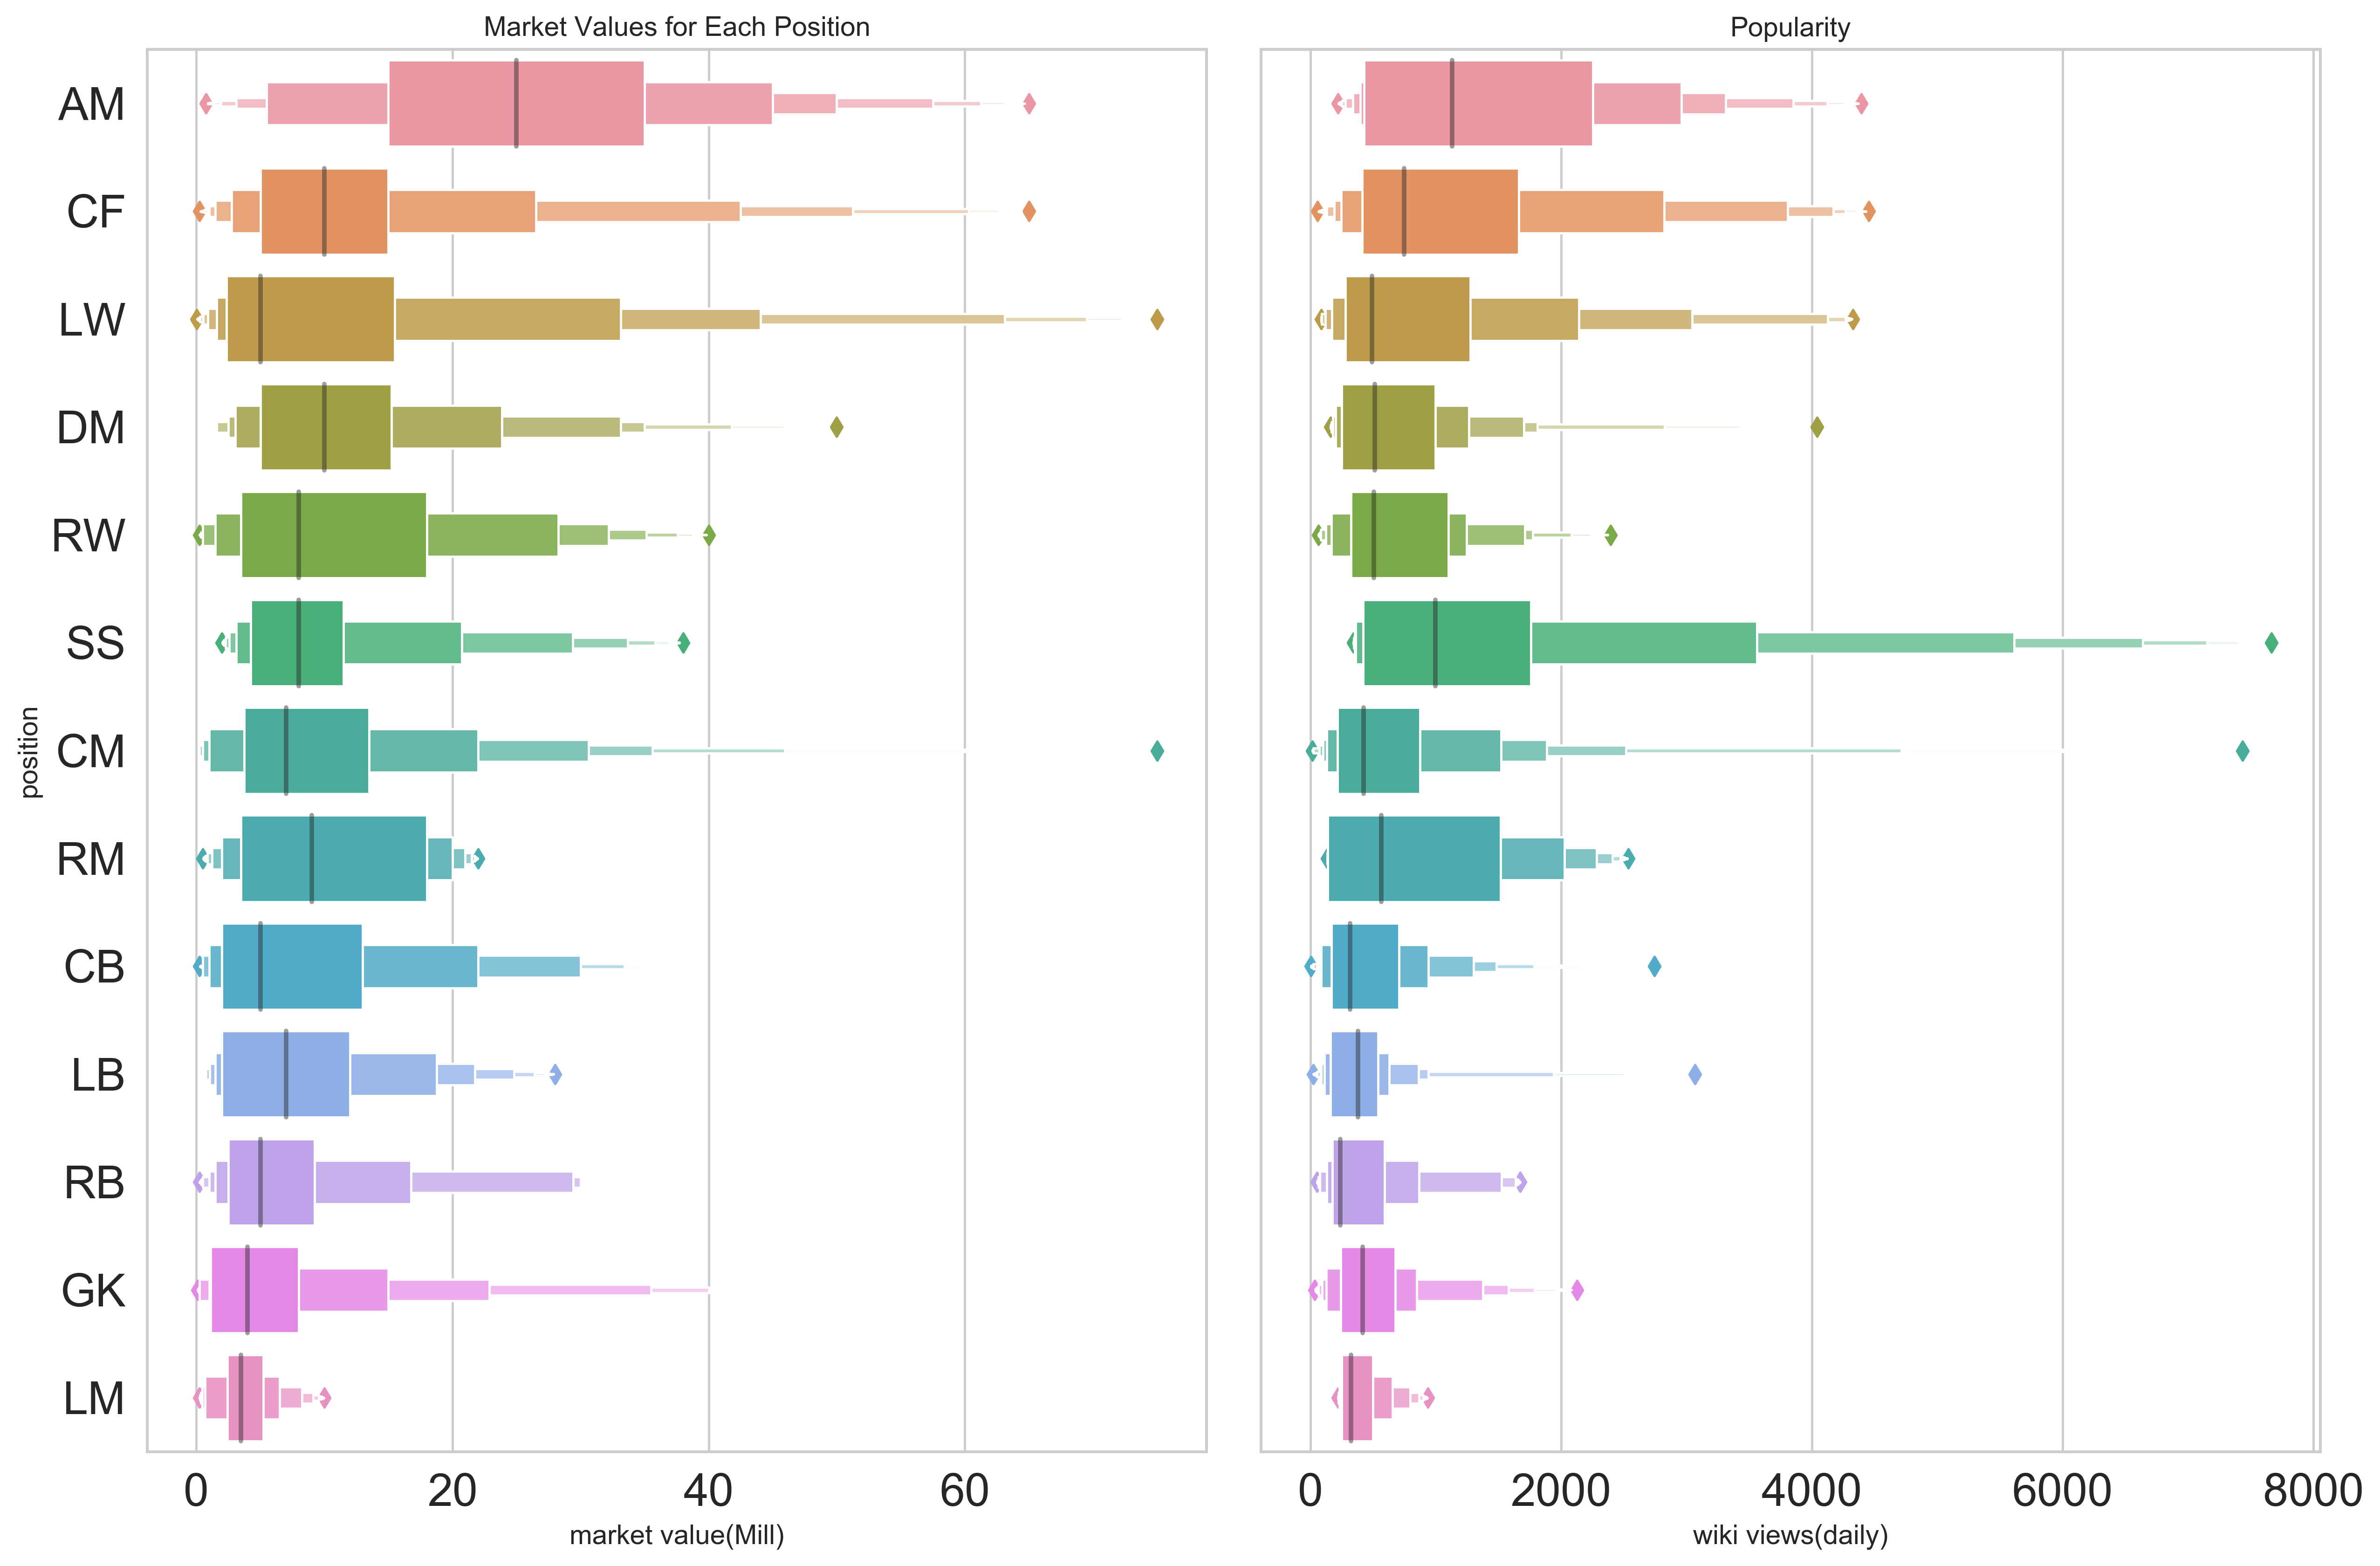

In [59]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.boxenplot(x="market value(Mill)", y="position", data=premier_league_df, ax=ax1, order=position_mean_order_idx)
sns.boxenplot(x="wiki views(daily)", y="position", data=premier_league_df, ax=ax2, order=position_mean_order_idx)

ax2.set_ylabel("")
ax1.set_title("Market Values for Each Position")
ax2.set_title("Popularity")

f.tight_layout()

* It is surprised that `left midfield(LM)` is the dying position in the 17/18 premier league. The players in that position has a surprising low market value median and the even sadder wikipedia views.
* `Second striker(SS)` is the favorite of the football fans. The daily wikipedia views for the player at that position is outstanding from the others.
* `Attacking midfield(AM)` the most valuable position in the premier league. The big chunk of players have arrange from 15 millions euro to 35 millions euro market values.

Let's see who is the favorite `second striker(SS)` in premier league

In [60]:
premier_league_df[premier_league_df["position"] == "SS"].sort_values("wiki views(daily)", ascending=False).head(1)

name     club  age position position category  \
143  Wayne Rooney  Everton   31       SS         attackers   

     market value(Mill)  wiki views(daily)  fpl value fpl select(%)  \
143                15.0               7664        7.5        20.90%   

     fpl points region category nationality  new foreign  big club  \
143          76         England     England        False     False   

     new signing  
143        False

It is the record goalscorer for the England national team and for Manchester United, Wayne Rooney.

<img src="source/wayne_rooney.jpg">

### The histogram of different position categories

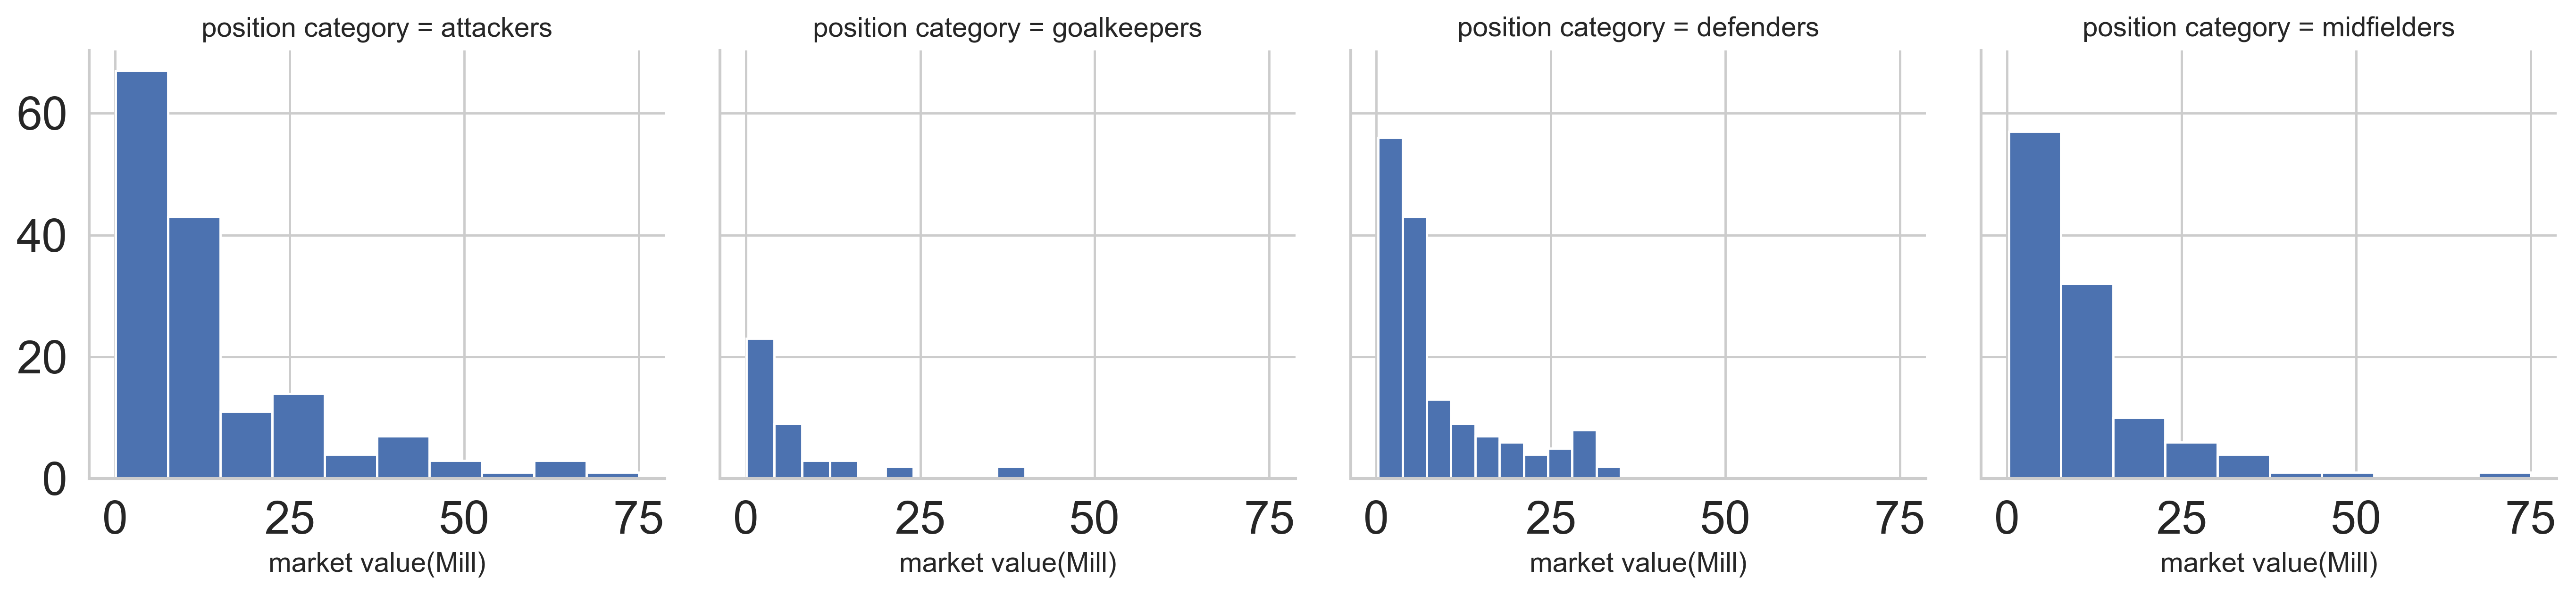

In [61]:
g = sns.FacetGrid(premier_league_df, col="position category", height=4)
g.map(plt.hist, "market value(Mill)")

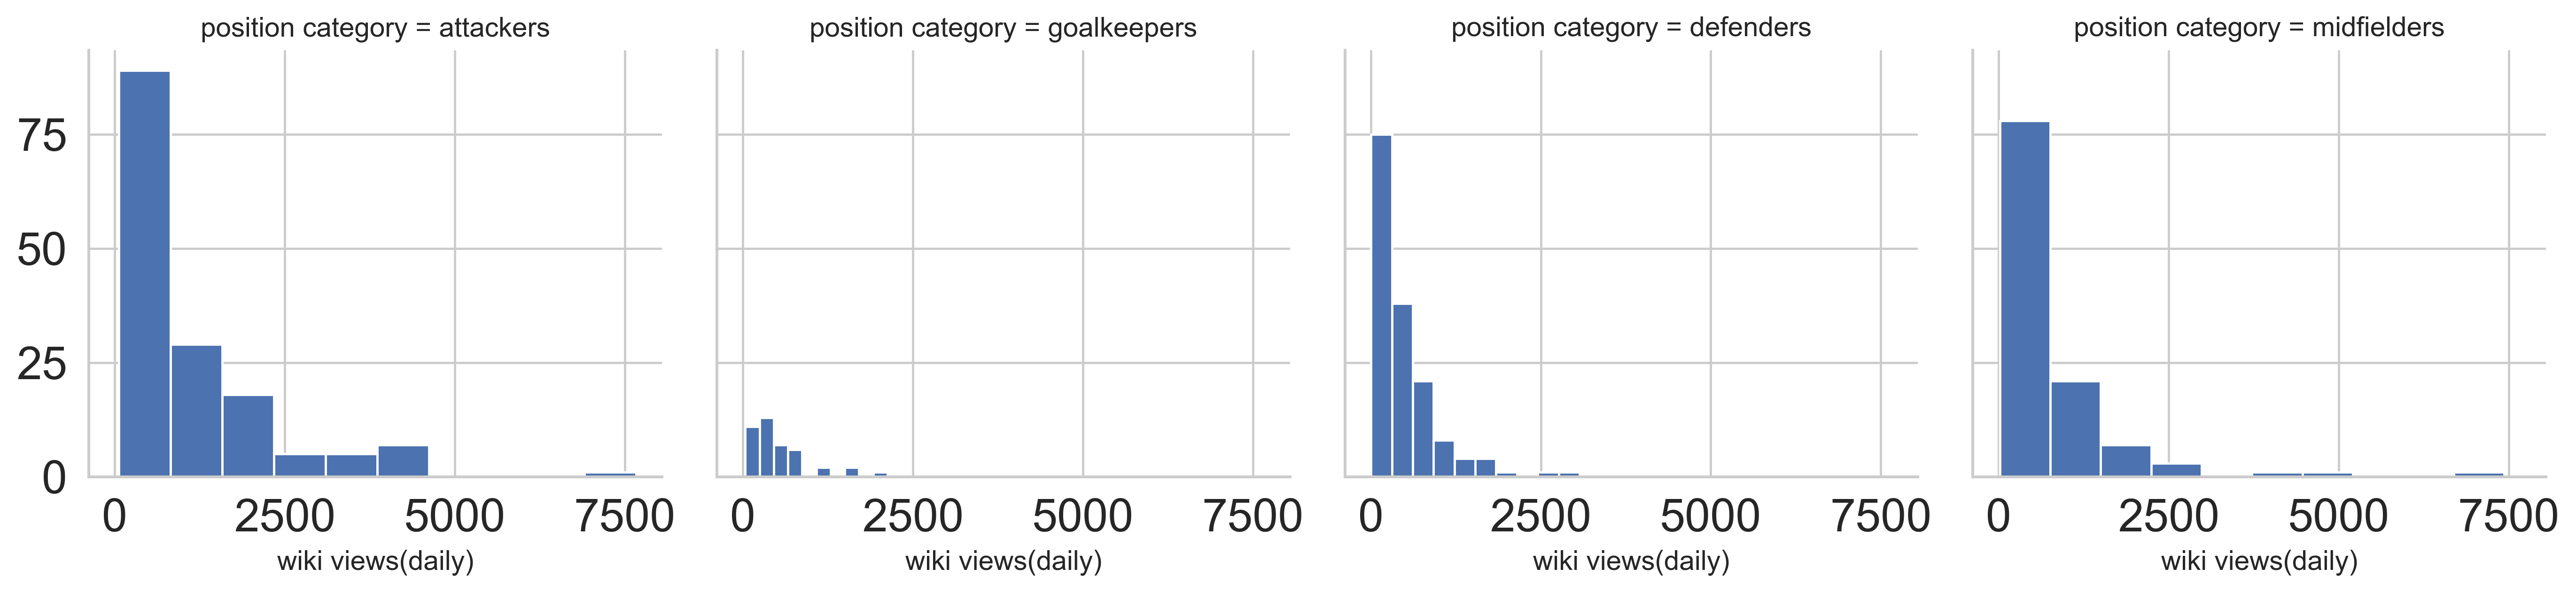

In [62]:
g = sns.FacetGrid(premier_league_df, col="position category", height=4)
g.map(plt.hist, "wiki views(daily)")

Attackers are the most valuable and popular position category in the premier league. On the contrary, the goal keepers are barely under the spotlight.

In [63]:
premier_league_df[premier_league_df["position category"] == "goalkeepers"].sort_values("market value(Mill)", ascending=False).head(3)

name               club  age position position category  \
261      David de Gea  Manchester United   26       GK       goalkeepers   
98   Thibaut Courtois            Chelsea   25       GK       goalkeepers   
380       Hugo Lloris  Tottenham Hotspur   30       GK       goalkeepers   

     market value(Mill)  wiki views(daily)  fpl value fpl select(%)  \
261                40.0               2126        5.5        26.10%   
98                 40.0               1260        5.5        18.50%   
380                24.0                847        5.5        12.60%   

     fpl points region category nationality  new foreign  big club  \
261         136              EU       Spain        False      True   
98          141              EU     Belgium        False      True   
380         143              EU      France        False      True   

     new signing  
261        False  
98         False  
380        False

The best two goalkeepers in premier league only has 40 millions euro value at 17/18 season.

## Conclusion
---
1. The market values of a club does have a positive relationship with the points it got in the end. However, the relationship become complex when the league is separated into two groups: "big clubs" and "small clubs".
2. New signing players data, comparing to all players, have a better linear relationship with the points. The more investments a club does in the summer market, the more chance to have a good ranking at the end of the season.
3. Not only the potential, the $\frac{market value(Mill)}{ (age)^2}$ factor can affects the points a club gained in this season. A young and talent attacker is a cornerstone for the club success.
4. Attack midfield is the position that most likely to have a high market values. However, the second striker is the most popular position among the fans. Goalkeeper is the position 